**This notebook implements three estimation methods. It does the following methods:**

1. Naive Random Walk

2. Censored Random Walk Based (a.k.a INVITE/U-INVITE)

3. Euclidean Similarity Network (Word Embeddings)

The first two are methods commonly used to obtain Semantic Networks from behavioral data (like verbal fluency) in the Psychology literature. The latter allows for a comparison of how spatial models trained on pre-existing written text might estimate networks from these same data.

## **INITIALIZE** ##

In [ ]:
# code from https://github.com/AusterweilLab/snafu-py/blob/master/snafu/__init__.py

import pickle
import networkx as nx
import numpy as np
#import scipy.cluster
#import scipy.stats
#import scipy
import operator
import math
import sys
import copy
import csv
import warnings
import json
import os
import sys


from numpy.linalg import inv
from itertools import *
from datetime import datetime

In [ ]:
! pip install pattern

In [ ]:
! pip install gensim

In [ ]:
import gensim
import pattern

## **LOADING DATA AS PANDAS DF**

*replace file path*

In [ ]:
# ALERT: REMEMBER TO MOUNT THE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
# read in fluency lists and create df of all the lists
url = "/content/drive/MyDrive/Annie Senior Thesis/Results, Semantic Network Models/Fluency Lists Processing Analysis/fluency_lists_v1/List_p0%02d - p0%02d.csv"
df = pd.read_csv(url % (7, 7))

for i in range (8, 50):

  # we are missing these participants
  if i in [16, 17, 27, 39]: continue

  df = pd.concat((df, pd.read_csv(url % (i, i))))


## **LOADING DATA: SNAFU FORMAT** ##

*replace file path*

In [ ]:
class Data():

    def __init__(self, data):

        self.rawdata = data

        def generateGroupSpace():
            items = data['items']
            groupitems={}
            idx=0
            for subitems in items:
                for item in list(items[subitems].values()):
                    if item not in list(groupitems.values()):
                        groupitems[idx] = item
                        idx += 1
            return groupitems

        self.groupitems = generateGroupSpace()
        self.groupnumnodes = len(self.groupitems)
        self.subs = sorted(data['Xs'].keys())
        self.listnums = [(sub, listnum) for sub in self.subs for listnum in sorted(self.rawdata['Xs'][sub].keys())]

        if data['structure']:
            self.structure = "hierarchical"
            self.hierarchical()
        else:
            self.structure = "nonhierarchical"
            self.nonhierarchical()
        return

    def hierarchical(self):

        Xs = copy.deepcopy(self.rawdata['Xs'])
        self.Xs = [[Xs[i][j] for j in sorted(Xs[i].keys())] for i in self.subs]
        self.lists = self.Xs

        items = copy.deepcopy(self.rawdata['items'])
        self.items = [items[i] for i in sorted(items.keys())]

        self.labeledXs = [numToItemLabel(self.Xs[i],self.items[i]) for i in range(len(self.Xs))]
        self.labeledlists = self.labeledXs

        spell_corrected = copy.deepcopy(self.rawdata['spell_corrected'])
        self.spell_corrected = [[spell_corrected[i][j] for j in sorted(spell_corrected[i].keys())] for i in self.subs]
        self.spelling_corrections = self.spell_corrected

        perseverations = copy.deepcopy(self.rawdata['perseverations'])
        self.perseverations = [[perseverations[i][j] for j in sorted(perseverations[i].keys())] for i in self.subs]

        intrusions = copy.deepcopy(self.rawdata['intrusions'])
        self.intrusions = [[intrusions[i][j] for j in sorted(intrusions[i].keys())] for i in self.subs]

        try:
            categories = copy.deepcopy(self.rawdata['categories'])
            self.categories = [[categories[i][j] for j in sorted(categories[i].keys())] for i in self.subs]
        except:
            self.categories = []

        try:
            irts = copy.deepcopy(self.rawdata['irts'])
            self.irts = [[irts[i][j] for j in sorted(irts[i].keys())] for i in self.subs]
        except:
            self.irts = []

        self.numnodes = [len(i) for i in self.items]
        self.structure = "hierarchical"

        return self

    def nonhierarchical(self):
        # map everyone to group space
        reverseGroup = reverseDict(self.groupitems)
        Xs = copy.deepcopy(self.rawdata['Xs'])
        items = copy.deepcopy(self.rawdata['items'])
        irts = copy.deepcopy(self.rawdata['irts'])
        spell_corrected = copy.deepcopy(self.rawdata['spell_corrected'])
        perseverations = copy.deepcopy(self.rawdata['perseverations'])
        intrusions = copy.deepcopy(self.rawdata['intrusions'])
        categories = copy.deepcopy(self.rawdata['categories'])

        for sub in Xs:
            for listnum in Xs[sub]:
                Xs[sub][listnum] = [reverseGroup[items[sub][i]] for i in Xs[sub][listnum]]

        self.Xs = flatten_list([[Xs[i][j] for j in sorted(Xs[i].keys())] for i in self.subs])
        self.lists = self.Xs
        self.spell_corrected = flatten_list([[spell_corrected[i][j] for j in sorted(spell_corrected[i].keys())] for i in self.subs])
        self.spelling_corrections = self.spell_corrected
        self.perseverations = flatten_list([[perseverations[i][j] for j in sorted(perseverations[i].keys())] for i in self.subs])
        self.intrusions = flatten_list([[intrusions[i][j] for j in sorted(intrusions[i].keys())] for i in self.subs])

        try:
            self.categories = flatten_list([[categories[i][j] for j in sorted(categories[i].keys())] for i in self.subs])
        except:
            self.categories = []

        try:
            self.irts = flatten_list([[irts[i][j] for j in sorted(irts[i].keys())] for i in self.subs])
        except:
            self.irts = []

        self.numnodes = self.groupnumnodes
        self.items = self.groupitems
        self.structure = "nonhierarchical"
        self.labeledXs = numToItemLabel(self.Xs, self.items)
        self.labeledlists = self.labeledXs

        return self

    def subs(self):
        return


def DataModel(data):
    tdkeys=list(data.keys())

    if 'trim' not in tdkeys:
        # FOR GENERATIVE PROCESS ONLY, NOT INFERRING GRAPHS.
        # Used to specify the length of a list as number of nodes (when 2+), OR
        # what proportion of network (when 0.0--1.0)
        data['trim'] = 1.0
    if 'jump' not in tdkeys:
        # jump with what probability?
        data['jump'] = 0.0
    if 'jumptype' not in tdkeys:
        # when jump > 0, is jumping 'uniform' probability or according to 'stationary' distribution?
        data['jumptype'] = "stationary"
    if 'start_node' not in tdkeys:
        # is start node chosen with 'uniform' probability or according to 'stationary' distribution?
        data['start_node'] = "stationary"
    if 'priming' not in tdkeys:
        # used to account for short-term memory priming when multiple fluency
        # lists are completed in one session. see Zemla & Austerweil (2017;
        # cogsci proceedings) for details
        data['priming'] = 0.0
    if 'jumponcensored' not in tdkeys:
        # FOR GENERATIVE PROCESS ONLY, NOT INFERRING GRAPHS.
        # instead of specifying a jump probability, you can jump after a fixed number of censored nodes
        data['jumponcensored'] = None
    if 'censor_fault' not in tdkeys:
        # with a fixed probability, repeated nodes are not censored
        data['censor_fault'] = 0.0
    if 'emission_fault' not in tdkeys:
        # FOR GENERATIVE PROCESS ONLY, NOT INFERRING GRAPHS.
        # with a fixed probability, new nodes are not emitted
        data['emission_fault'] = 0.0

    return dotdict(data)

def Irts(irts):
    irtkeys=list(irts.keys())

    if 'data' not in irtkeys:
        irts['data']=[]

    if 'irttype' not in irtkeys:
        if len(irts['data']) > 0:        # error unless empty dict (no IRTs)
            raise ValueError("Must specify 'irttype' in irts!")
        else:
            irts['irttype']="none"

    if 'rcutoff' not in irtkeys:
        irts['rcutoff']=20

    if irts['irttype'] == "gamma":
        if 'gamma_beta' not in irtkeys:
            irts['gamma_beta'] = (1/1.1)
            #warnings.warn("Using default beta (Gamma IRT) weight of "+str(irts['gamma_beta']))
    if irts['irttype'] == "exgauss":
        if 'exgauss_lambda' not in irtkeys:
            irts['exgauss_lambda'] = 0.5
            #warnings.warn("Using default exgauss_lambda (Ex-Gaussian IRT) weight of "+str(irts['exgauss_lambda']))
        if 'exgauss_sigma' not in irtkeys:
            irts['exgauss_sigma'] = 0.5
            #warnings.warn("Using default exgauss_sigma (Ex-Gaussian IRT) weight of "+str(irts['exgauss_sigma']))

    return dotdict(irts)

def Fitinfo(fitinfo):
    fitkeys=list(fitinfo.keys())

    if 'followtype' not in fitkeys:
        fitinfo['followtype'] = "avg"   # or max or random
    #if 'prior_method' not in fitkeys:
    #    fitinfo['prior_method'] = "zeroinflatedbetabinomial"
    if 'zibb_p' not in fitkeys:
        fitinfo['zibb_p'] = 0.5
    if 'prior_b' not in fitkeys:
        fitinfo['prior_b'] = 1
    if 'prior_a' not in fitkeys:        # adjust default prior_a depending on BB or ZIBB, to make edge prior .5
        if fitinfo['zibb_p'] == 0.0:    # non-zero inflated betabinomial
            fitinfo['prior_a'] = fitinfo['prior_b']
        else:
            fitinfo['prior_a'] = fitinfo['prior_b'] / float(fitinfo['zibb_p'])
    if 'directed' not in fitkeys:
        fitinfo['directed'] = False
    if 'startGraph' not in fitkeys:
        fitinfo['startGraph'] = "cn_valid"
    if 'prune_limit' not in fitkeys:
        fitinfo['prune_limit'] = np.inf
    if 'triangle_limit' not in fitkeys:
        fitinfo['triangle_limit'] = np.inf
    if 'other_limit' not in fitkeys:
        fitinfo['other_limit'] = np.inf
    if 'cn_windowsize' not in fitkeys:
        fitinfo['cn_windowsize'] = 2
    if 'cn_threshold' not in fitkeys:
        fitinfo['cn_threshold'] = 2
    if 'cn_alpha' not in fitkeys:
        fitinfo['cn_alpha'] = 0.05
    if 'estimatePerseveration' not in fitkeys:
        fitinfo['estimatePerseveration'] = False

    return dotdict(fitinfo)

In [ ]:
# take list of lists in number/node and translate back to items using dictionary (e.g., 1->dog, 2->cat)
def numToItemLabel(data, items):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    new_data=[]
    for l in data:
        new_data.append([])
        for i in l:
            new_data[-1].append(items[i])
    return new_data

In [ ]:
def reverseDict(items):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    newitems=dict()
    for itemnum in items:
        itemlabel = items[itemnum]
        newitems[itemlabel] = itemnum
    return newitems

In [ ]:
def flatten_list(l, numtimes=1):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    l1 = [item for sublist in l if isinstance(sublist,list) or isinstance(sublist,np.ndarray) for item in sublist]
    l = l1+[item for item in l if not isinstance(item,list) and not isinstance(item,np.ndarray)]
    if numtimes > 1:
        l = flatten_list(l, numtimes-1)
    return l

In [ ]:
def load_fluency_data(filepath,category=None,removePerseverations=False,removeIntrusions=False,spell=None,scheme=None,group=None,subject=None,removeNonAlphaChars=False,hierarchical=False,targetletter=None):
    if targetletter:
        targetletter = targetletter.lower()
    if type(group) is str:
        group = [group]
    if type(subject) is str:
        subject = [subject]
    if type(category) is str:
        category = [category]

    # grab header col indices
    mycsv = csv.reader(open(filepath,'rt', encoding='utf-8-sig'))
    headers = next(mycsv, None)
    subj_col = headers.index('id')
    listnum_col = headers.index('listnum')
    item_col = headers.index('item')

    # check for optional columns
    try:
        category_col = headers.index('category')
        has_category_col = True
    except:
        has_category_col = False
    try:
        group_col = headers.index('group')
        has_group_col = True
    except:
        has_group_col = False
        if group:
            raise ValueError('Data file does not have grouping column, but you asked for a specific group.')
    try:
        rt_col = headers.index('rt')
        has_rt_col = True
    except:
        has_rt_col = False

    Xs=dict()
    irts=dict()
    categories=dict()
    items=dict()
    spellingdict=dict()
    spell_corrected = dict()
    perseverations = dict()
    intrusions = dict()
    validitems=[]

    # read in list of valid items when removeIntrusions = True
    if removeIntrusions:
        if (not scheme) and (not targetletter):
            raise ValueError('You need to provide a scheme or targetletter if you want to ignore intrusions!')
        elif scheme:
            with open(scheme,'rt', encoding='utf-8-sig') as fh:
                for line in fh:
                    if line[0] == "#": continue         # skip commented lines
                    try:
                        validitems.append(line.rstrip().split(',')[1].lower())
                    except:
                        pass    # fail silently on wrong format

    # read in spelling correction dictionary when spell is specified
    if spell:
        with open(spell,'rt', encoding='utf-8-sig') as spellfile:
            for line in spellfile:
                if line[0] == "#": continue         # skip commented lines
                try:
                    correct, incorrect = line.rstrip().split(',')
                    spellingdict[incorrect] = correct
                except:
                    pass    # fail silently on wrong format

    with open(filepath,'rt', encoding='utf-8-sig') as f:
        f.readline()    # discard header row
        for line in f:
            if line[0] == "#": continue         # skip commented lines
            row = line.rstrip().split(',')

            storerow = True  # if the row meets the filters specified then load it, else skip it
            if (subject != None) and (row[subj_col] not in subject):
                storerow = False
            if (group != None) and (row[group_col] not in group):
                storerow = False
            if (category != None) and (row[category_col] not in category):
                storerow = False

            if storerow == True:

                idx = row[subj_col]
                listnum_int = int(row[listnum_col])

                # make sure dict keys exist
                if idx not in Xs:
                    Xs[idx] = dict()
                    spell_corrected[idx] = dict()
                    perseverations[idx] = dict()
                    intrusions[idx] = dict()
                    if has_rt_col:
                        irts[idx] = dict()
                    if has_category_col:
                        categories[idx] = dict()
                if listnum_int not in Xs[idx]:
                    Xs[idx][listnum_int] = []
                    spell_corrected[idx][listnum_int] = []
                    perseverations[idx][listnum_int] = []
                    intrusions[idx][listnum_int] = []
                    if has_rt_col:
                        irts[idx][listnum_int] = []
                    if has_category_col:
                        categories[idx][listnum_int] = row[category_col]
                if idx not in items:
                    items[idx] = dict()

                # basic clean-up
                item=row[item_col].lower()
                if removeNonAlphaChars:
                    goodchars = []
                    for char in item:
                        if char.isalpha():
                            goodchars.append(char)
                    item = "".join(goodchars)
                if item in list(spellingdict.keys()):
                    newitem = spellingdict[item]
                    spell_corrected[idx][listnum_int].append((item, newitem))
                    item = newitem
                if has_rt_col:
                    irt=row[rt_col]
                if item not in list(items[idx].values()):
                    if (item in validitems) or (not removeIntrusions) or (item[0] == targetletter):
                        item_count = len(items[idx])
                        items[idx][item_count]=item
                    else:
                        intrusions[idx][listnum_int].append(item) # record as intrusion

                # add item to list
                try:
                    itemval=list(items[idx].values()).index(item)
                    if (not removePerseverations) or (itemval not in Xs[idx][listnum_int]):   # ignore any duplicates in same list resulting from spelling corrections
                        if (item in validitems) or (not removeIntrusions) or (item[0] == targetletter):
                            Xs[idx][listnum_int].append(itemval)
                            if has_rt_col:
                                irts[idx][listnum_int].append(int(irt))
                    else:
                        perseverations[idx][listnum_int].append(item) # record as perseveration
                except:
                    pass                # bad practice to have empty except

    return Data({'Xs': Xs, 'items': items, 'irts': irts, 'structure': hierarchical, 'categories': categories,
                 'spell_corrected': spell_corrected, 'perseverations': perseverations, 'intrusions': intrusions})

In [ ]:
filepath = '/content/drive/MyDrive/Annie Senior Thesis/Results, Semantic Network Models/LexPlay_animals.csv'
category="animals"

lexplay_animals = load_fluency_data(filepath)

In [ ]:
filepath = '/content/drive/MyDrive/Annie Senior Thesis/Results, Semantic Network Models/LexPlay_foods.csv'
category="foods"

lexplay_foods = load_fluency_data(filepath)

In [ ]:
filepath = '/content/drive/MyDrive/Annie Senior Thesis/Results, Semantic Network Models/LexPlay_zoo.csv'
category="zoo"

lexplay_zoo = load_fluency_data(filepath)

In [ ]:
filepath = '/content/drive/MyDrive/Annie Senior Thesis/Results, Semantic Network Models/LexPlay_grocery.csv'
category="grocery"

lexplay_grocery = load_fluency_data(filepath)

In [ ]:
filepath = '/content/drive/MyDrive/Annie Senior Thesis/Results, Semantic Network Models/LexPlay_animals_simplified.csv'
category="animals"

lexplay_animals_s = load_fluency_data(filepath)

In [ ]:
filepath = '/content/drive/MyDrive/Annie Senior Thesis/Results, Semantic Network Models/LexPlay_foods_simplified.csv'
category="foods"

lexplay_foods_s = load_fluency_data(filepath)

In [ ]:
filepath = '/content/drive/MyDrive/Annie Senior Thesis/Results, Semantic Network Models/LexPlay_zoo_simplified.csv'
category="zoo"

lexplay_zoo_s = load_fluency_data(filepath)

In [ ]:
filepath = '/content/drive/MyDrive/Annie Senior Thesis/Results, Semantic Network Models/LexPlay_grocery_simplified.csv'
category="grocery"

lexplay_grocery_s = load_fluency_data(filepath)

## **Getting fluency lists from pandas df** ##

*replace file path*

In [ ]:
# some cleaning
import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
url_participants = '/content/drive/MyDrive/Annie Senior Thesis/Results, Semantic Network Models/LexPlay Participant Spreadsheet - ParticipantInfo.csv'
df_participants = pd.read_csv(url_participants)

In [ ]:
df_participants

Participant ID        Condition  \
0                                                   1                0   
1                                                   2                1   
2                                                   3                2   
3                                                   4                3   
4                                                   5                4   
..                                                ...              ...   
70  ^^ Will work on a script to process and count ...              NaN   
71       ^^ Will go back in and fix 7-30 accordingly.              NaN   
72                                                NaN              NaN   
73        running list of things i'm tracking/coding:              NaN   
74                                     Participant ID  Timestamp start   

        age_group      family_id         date         age_mos experimenter  \
0              5y          4457c         9/20           67.11           AJ   
1              6y          4265b         9/22           72.15           AJ   
2              6y          4258a         9/24           75.29           AJ   
3              5y          4372b         9/24           70.06           AJ   
4              5y           180b         9/24           61.12           AJ   
..            ...            ...          ...             ...          ...   
70            NaN            NaN          NaN             NaN          NaN   
71            NaN            NaN          NaN             NaN          NaN   
72            NaN            NaN          NaN             NaN          NaN   
73            NaN            NaN          NaN             NaN          NaN   
74  timestamp end  Transcription  Category ID  Category Label        Round   

                      pilot full recording    break activity Unnamed: 10  \
0                         y              n             craft         NaN   
1                         n              n             craft         NaN   
2                         n              n             craft         NaN   
3                         n              n             craft         NaN   
4                         n              n             craft         NaN   
..                      ...            ...               ...         ...   
70                      NaN            NaN               NaN         NaN   
71                      NaN            NaN               NaN         NaN   
72                      NaN            NaN               NaN         NaN   
73                      NaN            NaN               NaN         NaN   
74  corrected_transcription        exclude  hard to decipher   intrusion   

                   room            done  \
0                office               y   
1             fish bowl               y   
2             fish bowl               y   
3             fish bowl               y   
4                office               y   
..                  ...             ...   
70                  NaN             NaN   
71                  NaN             NaN   
72                  NaN             NaN   
73                  NaN             NaN   
74  corrected intrusion  classification   

                                                notes Unnamed: 14  \
0                                                 NaN         NaN   
1   praat recording buffer set to 60 so recording ...         NaN   
2   praat recording buffer set to 60 so recording ...         NaN   
3   praat recording buffer set to 60 so recording ...         NaN   
4   praat recording buffer set to 60 so recording ...         NaN   
..                                                ...         ...   
70                                                NaN         NaN   
71                                                NaN         NaN   
72                                                NaN         NaN   
73                                                NaN         NaN   
74                      

In [ ]:
age_year = df_participants['age_group'][0:49]
for i in range(len(age_year)):
  age_year[i] = age_year[i][0]

In [ ]:
age_mos = df_participants['age_mos'][0:49]
age_mos

0      67.11
1      72.15
2      75.29
3      70.06
4      61.12
5         85
6       92.3
7      75.18
8      89.02
9      64.24
10     76.15
11     74.28
12     60.12
13      96.3
14     95.22
15     87.05
16     69.22
17     82.27
18     84.25
19      68.1
20     74.26
21      84.1
22     71.03
23    102.17
24     64.18
25     80.01
26     89.17
27     68.21
28     98.09
29     81.17
30    106.28
31     77.05
32     68.03
33     95.25
34     98.17
35     66.19
36     98.03
37     73.27
38     89.07
39     86.19
40     80.06
41        79
42    106.08
43     64.16
44     92.01
45     94.28
46     68.15
47     65.28
48     65.28
Name: age_mos, dtype: object

In [ ]:
from pattern.text.en import singularize

# reformat the fluency data as matrices for each category, parameters available to tune for categories and age
def get_fluency_lists(df, age_year, age_mos, category=('toys','animals', 'foods', 'zoo', 'grocery'), mos=(60, 109), years = (5,9), removemissing=False):

  # get relevant participant ids
  relevant_ids = []
  for i in range(len(age_year)):
    # we do not have full recordings for participants 1 to 6
    if i in range(0,6): continue
    # we do not have recordings for the following participants
    if i+1 in [16, 17, 27, 39]: continue
    # if we are not adding the participants missing lists
    if removemissing:
      if i+1 in [33, 34]: continue
    # add participant if in search ranges
    if (float(age_year[i]) in range(years[0], years[1])) & ((float(age_mos[i]) > mos[0]) & (float(age_mos[i]) < mos[1])): relevant_ids.append(i+1)

  # initialize list of lists
  get_toys = False
  get_animals = False
  get_food = False
  get_zoo = False
  get_grocery = False
  toy_lists = ''
  animals_lists = ''
  food_lists = ''
  zoo_lists = ''
  grocery_lists = ''

  if 'toys' in category:
    get_toys = True
    toy_lists = []
  if 'animals' in category:
    get_animals = True
    animal_lists = []
  if 'foods' in category:
    get_food = True
    food_lists = []
  if 'zoo' in category:
     get_zoo = True
     zoo_lists = []
  if 'grocery' in category:
    get_grocery = True
    grocery_lists = []

  # go through df and add relevant utterances to above lists
  for id in relevant_ids:
    for round in range(0, 5):

      if get_toys: toys = []
      if get_animals: animals = []
      if get_food: food = []
      if get_zoo: zoo = []
      if get_grocery: grocery = []

      this_df = df[df['participant_id'] == id]
      this_df = this_df[this_df['round'] == round]
      for i, row in this_df.iterrows():
        this_category = row['category']
        if get_toys & (this_category == 'toys'): toys.append(singularize(row['item'].lower()))
        elif get_animals & (this_category == 'animals'): animals.append(singularize(row['item'].lower()))
        elif get_food & (this_category == 'foods'): food.append(singularize(row['item'].lower()))
        elif get_zoo & (this_category == 'zoo'): zoo.append(singularize(row['item'].lower()))
        elif get_grocery & (this_category == 'grocery'): grocery.append(singularize(row['item'].lower()))



      if get_toys and toys!=[]: toy_lists.append(toys)
      if get_animals and animals !=[]: animal_lists.append(animals)
      if get_food and food!=[]: food_lists.append(food)
      if get_zoo and zoo!=[]: zoo_lists.append(zoo)
      if get_grocery and grocery!=[]: grocery_lists.append(grocery)

    # take care of participant 33's missing zoo list and 34's missing grocery list
    if id==33: zoo_lists.append([])
    if id==34: grocery_lists.append([])

  return relevant_ids, toy_lists, animal_lists, food_lists, zoo_lists, grocery_lists


In [ ]:
relevant_ids, toy_lists, animal_lists, food_lists, zoo_lists, grocery_lists = get_fluency_lists(df, age_year, age_mos)

In [ ]:
# strip adjectives etc. to simplify list
def simplify_list(l):
  new_l = []

  for w in l:
    new_w = ''
    tokenized = word_tokenize(w.lower())
    tagged = pos_tag(tokenized)
    exists = False
    for token in tagged:
      # remove the unclears
      if token[0] == ']': continue
      # don't add baby (doesn't seem to be considered as adj)
      if token[0] == 'baby': continue
      if token[0] == 'awesome': continue
      if token[0] == 'yeah': continue
      if token[0] == 'decipher': continue
      # add if noun
      if token[1] == 'NN':
        if exists: new_w += ' ' + token[0]
        else:
          new_w += token[0]
          exists = True
    if exists:
      new_l.append(new_w)

  return new_l

In [ ]:
# strip adjectives etc. to simplify list
def simplify_lists(lists):
  new_lists = []
  for l in lists:
    new_l = []
    for w in l:
      new_w = ''
      tokenized = word_tokenize(w.lower())
      tagged = pos_tag(tokenized)
      exists = False
      for token in tagged:
        # remove the unclears
        if token[0] == ']': continue
        # don't add baby (doesn't seem to be considered as adj)
        if token[0] == 'baby': continue
        if token[0] == 'awesome': continue
        if token[0] == 'yeah': continue
        if token[0] == 'decipher': continue
        # add if noun
        if token[1] == 'NN':
          if exists: new_w += ' ' + token[0]
          else:
            new_w += token[0]
            exists = True
      if exists:
        new_l.append(new_w)
    new_lists.append(new_l)

  return new_lists


## **Naive Random Walk (On Unsimplified Lists)**##



In [ ]:
# function written with help of Chat GPT
# Look at what SNAFU people did

# function from snafu
def flatten_list(l, numtimes=1):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    l1 = [item for sublist in l if isinstance(sublist,list) or isinstance(sublist,np.ndarray) for item in sublist]
    l = l1+[item for item in l if not isinstance(item,list) and not isinstance(item,np.ndarray)]
    if numtimes > 1:
        l = flatten_list(l, numtimes-1)
    return l # modified

    # flat list from tuple walk
def nodes_from_edges(walk):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    path=list(list(zip(*walk))[0]) # first element from each tuple
    path.append(walk[-1][1]) # second element from last tuple
    return path

  # tuple walk from flat list
def edges_from_nodes(path):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    walk=[]
    for i in range(len(path)-1):
        walk.append((path[i],path[i+1]))
    return walk


from functools import reduce

def naiveRandomWalk(Xs, numnodes=None, directed=False):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    # THIS DOESN'T WORK PROPERLY, PASS IN NUMNODES AS ARGUMENT
    if numnodes == None:
        numnodes = len(set(flatten_list(flatten_list(Xs)))) #modified because flatten_list once wasn't working
    a=np.zeros((numnodes,numnodes))
    for x in Xs:
        walk = edges_from_nodes(flatten_list(x))
        for i in set(walk):
            a[i[0],i[1]]=1
            if directed==False:
                a[i[1],i[0]]=1
    a=np.array(a.astype(int))
    return a

In [ ]:
# testing this function on animals
nrw_network = naiveRandomWalk(lexplay_animals.Xs, numnodes=lexplay_animals.groupnumnodes)

In [ ]:
nrw_network

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

## **CREATE NRW GRAPH (unsimplified lists)** ##
Create graph object using NRW adjacency matrix and visualize

Note: adjacency matrx indices correspond to labels in fluency_data.groupitems dictionary

In [ ]:
import matplotlib.pyplot as plt

def nrw_graph(a, numnodes, groupitems):

  # Create a graph for visualization
  G_semantic = nx.Graph()

  for i in range(numnodes):
    for j in range(numnodes):
      if a[i][j] == 1:
        G_semantic.add_node(groupitems[i])
        G_semantic.add_node(groupitems[j])
        G_semantic.add_edge(groupitems[i], groupitems[j], weight=1)

  pos = nx.spring_layout(G_semantic)
  edge_labels = {(u, v): d['weight'] for u, v, d in G_semantic.edges(data=True)}

  plt.figure(figsize=(15, 15))
  nx.draw_networkx_nodes(G_semantic, pos, node_size=25, node_color='skyblue')
  nx.draw_networkx_labels(G_semantic, pos, font_size=10, font_color='purple')
  nx.draw_networkx_edges(G_semantic, pos, edgelist=G_semantic.edges(), width=[d['weight'] / 10 for u, v, d in G_semantic.edges(data=True)])
  #nx.draw_networkx_edge_labels(G_semantic, pos, edge_labels=edge_labels, font_size=8)
  plt.axis('off')
  plt.title('Semantic Network')
  plt.show()

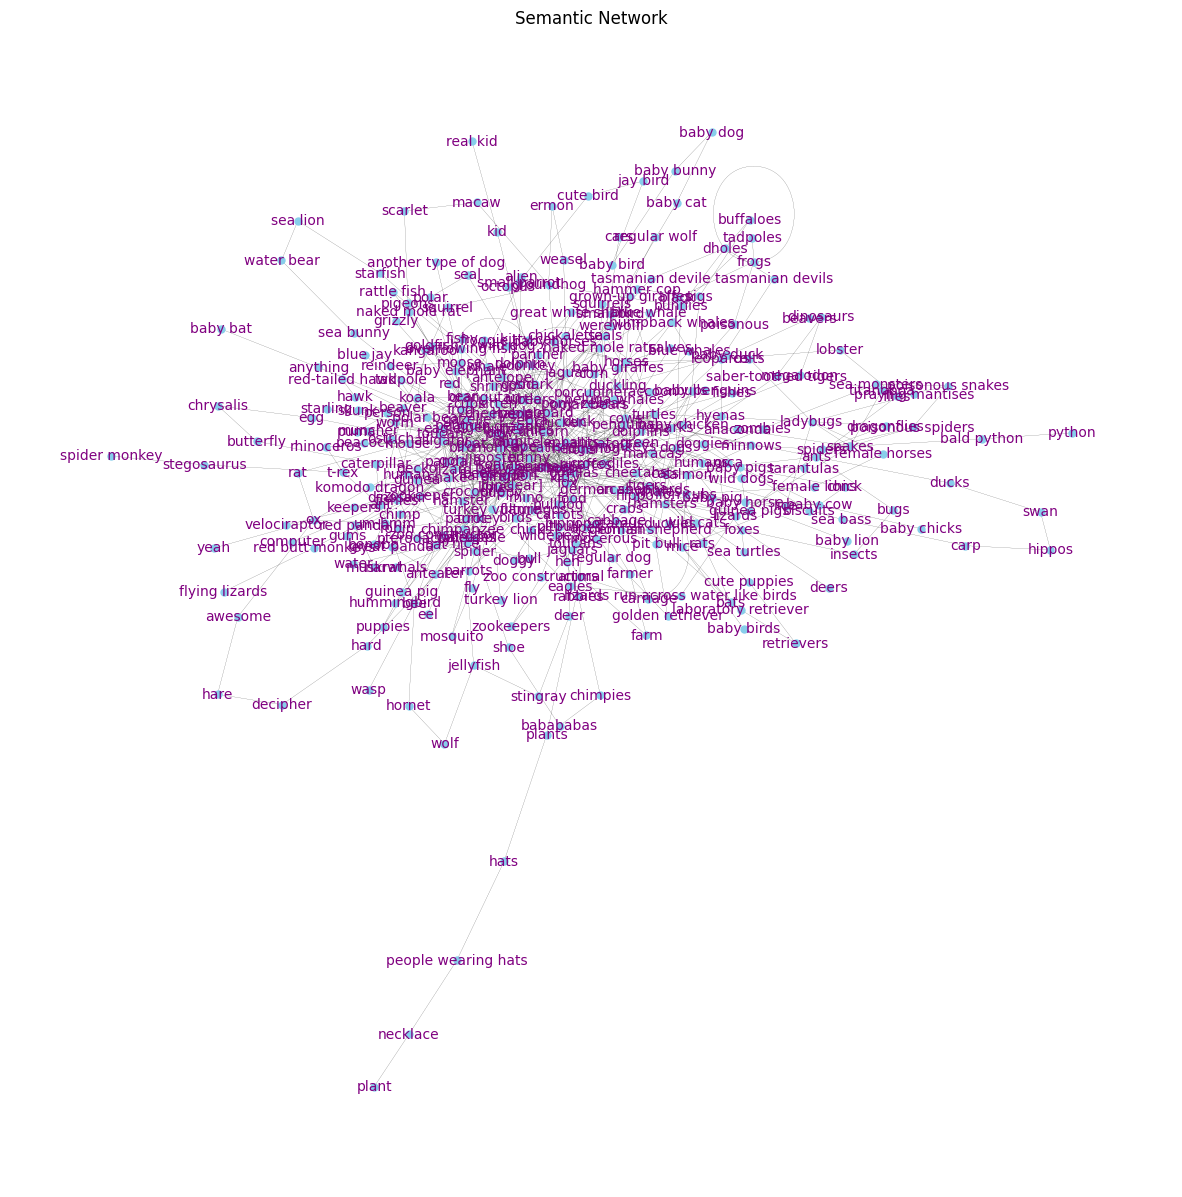

In [ ]:
nrw_graph(nrw_network, lexplay_animals.groupnumnodes, lexplay_animals.groupitems)

In [ ]:
foods_nrw = naiveRandomWalk(lexplay_foods.Xs, numnodes=lexplay_foods.groupnumnodes)

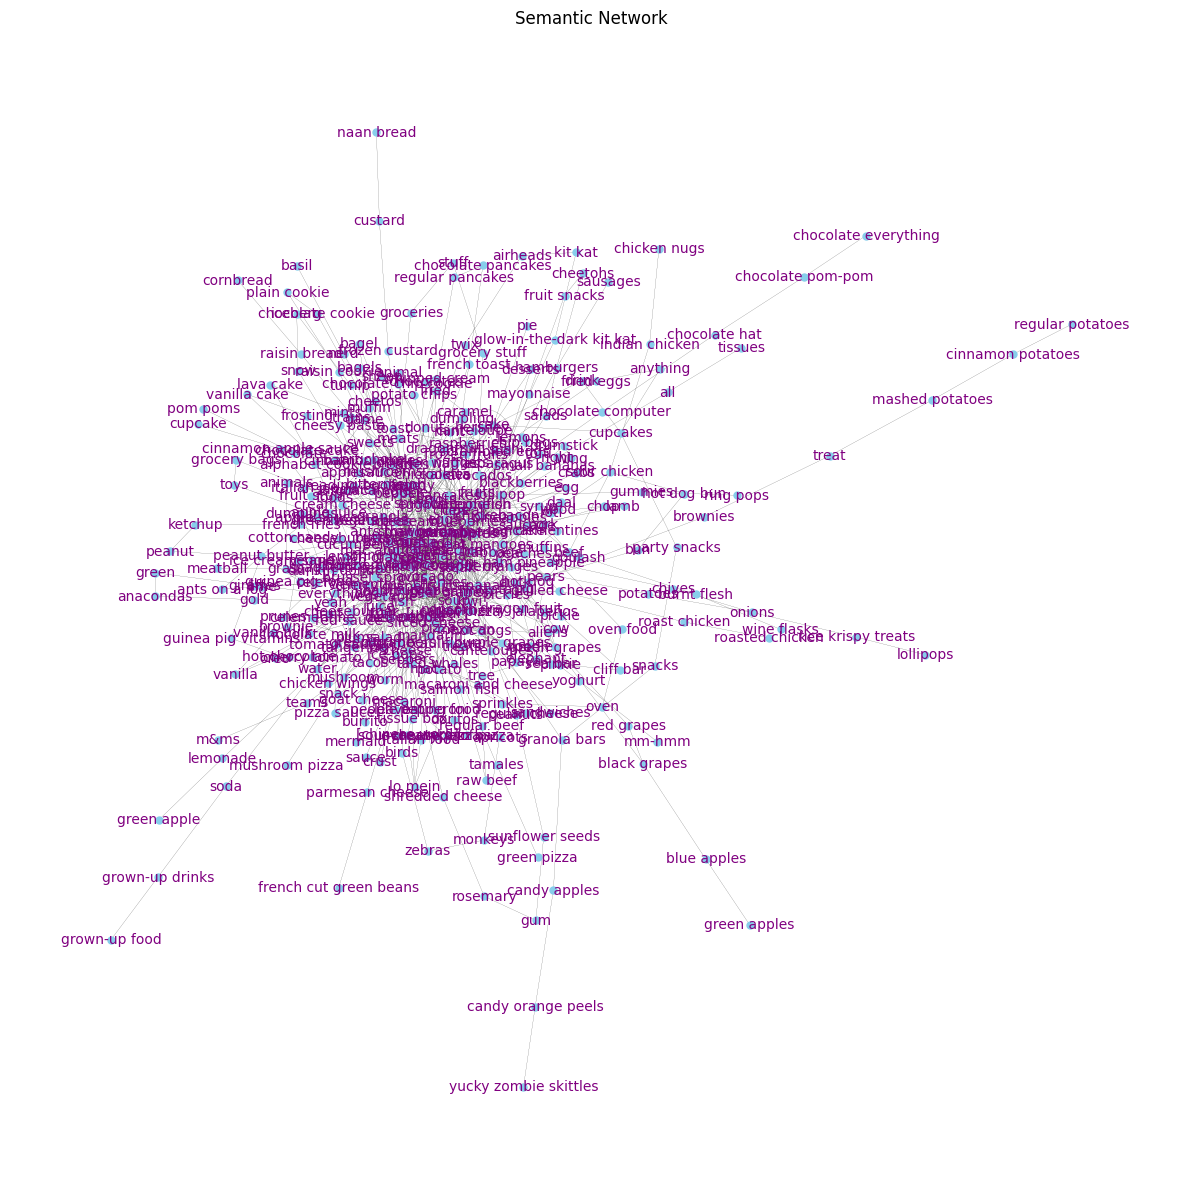

In [ ]:
nrw_graph(foods_nrw, lexplay_foods.groupnumnodes, lexplay_foods.groupitems)

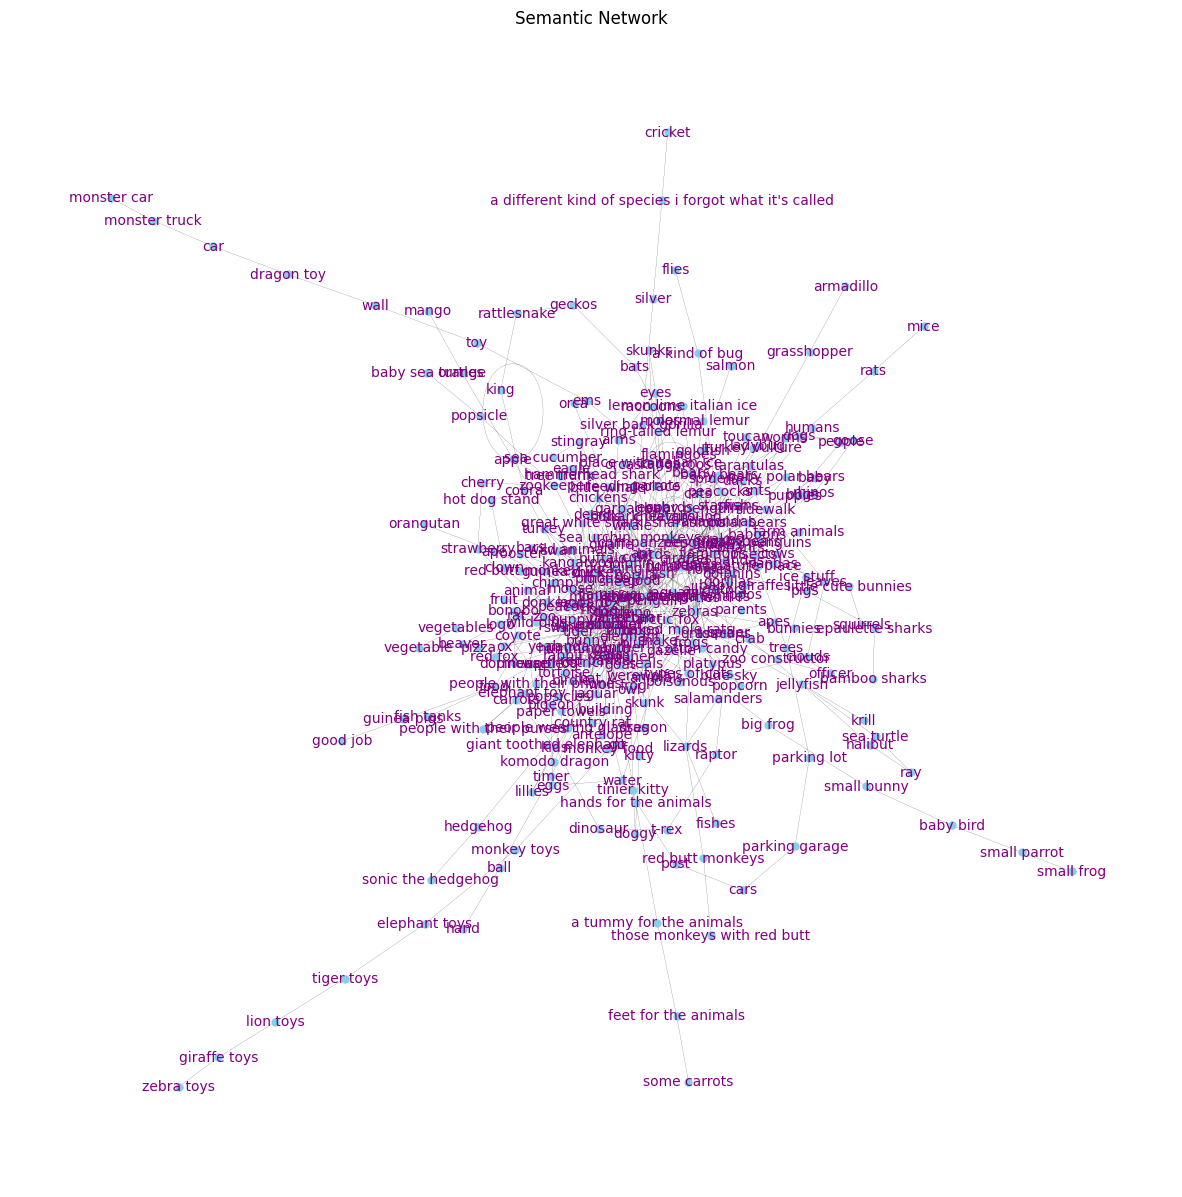

In [ ]:
zoo_nrw = naiveRandomWalk(lexplay_zoo.Xs, numnodes=lexplay_zoo.groupnumnodes)
nrw_graph(zoo_nrw, lexplay_zoo.groupnumnodes, lexplay_zoo.groupitems)

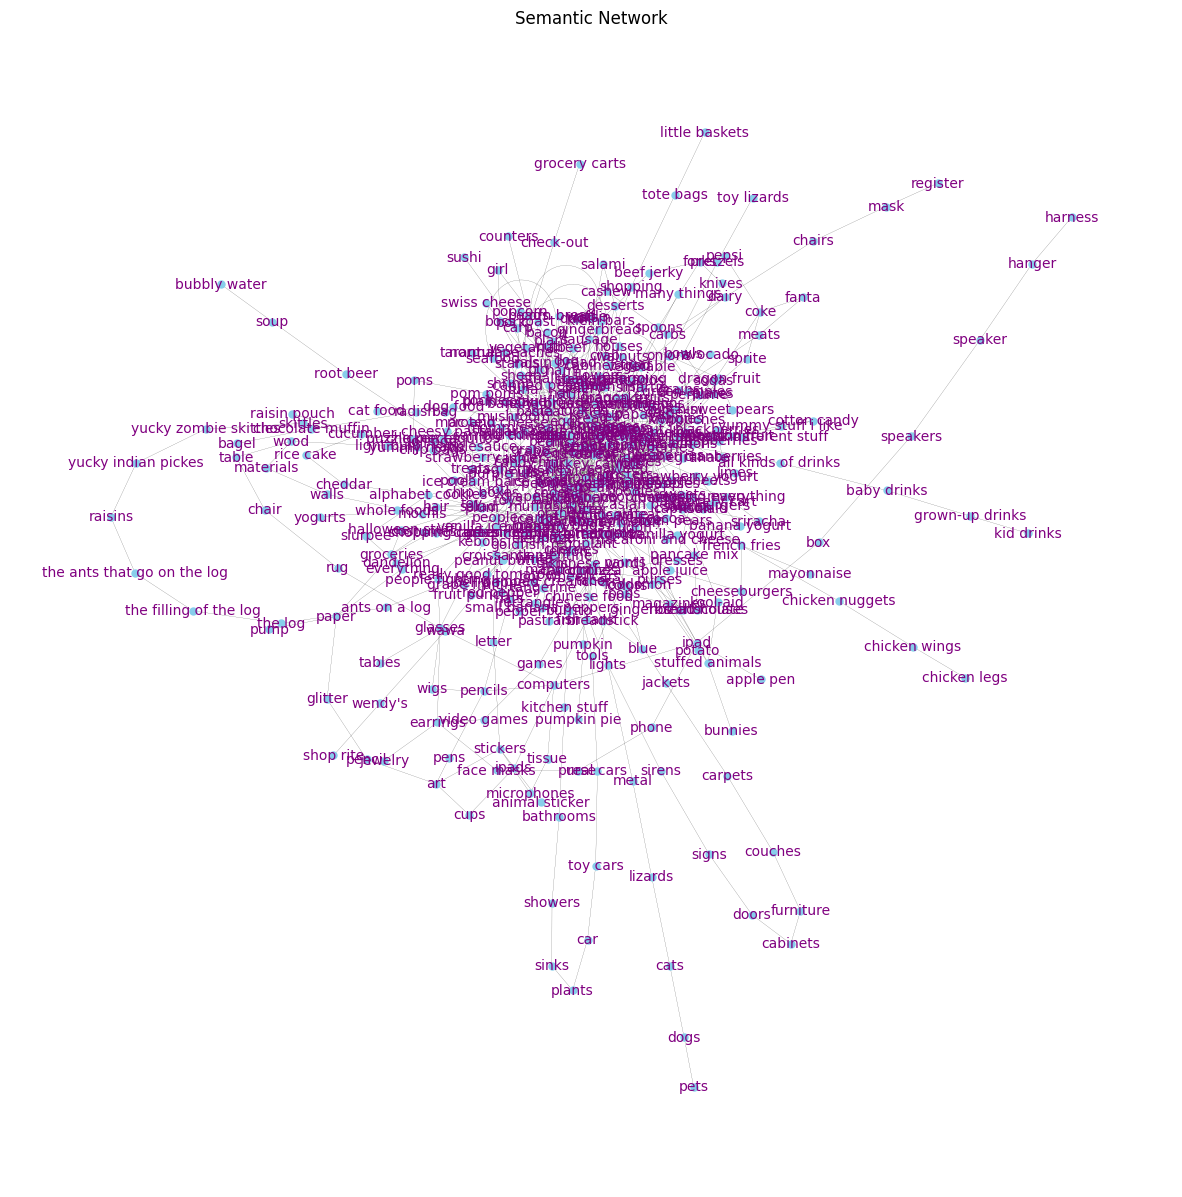

In [ ]:
grocery_nrw = naiveRandomWalk(lexplay_grocery.Xs, numnodes=lexplay_grocery.groupnumnodes)
nrw_graph(grocery_nrw, lexplay_grocery.groupnumnodes, lexplay_grocery.groupitems)

## **NRW graphs (simplified lists)** ##

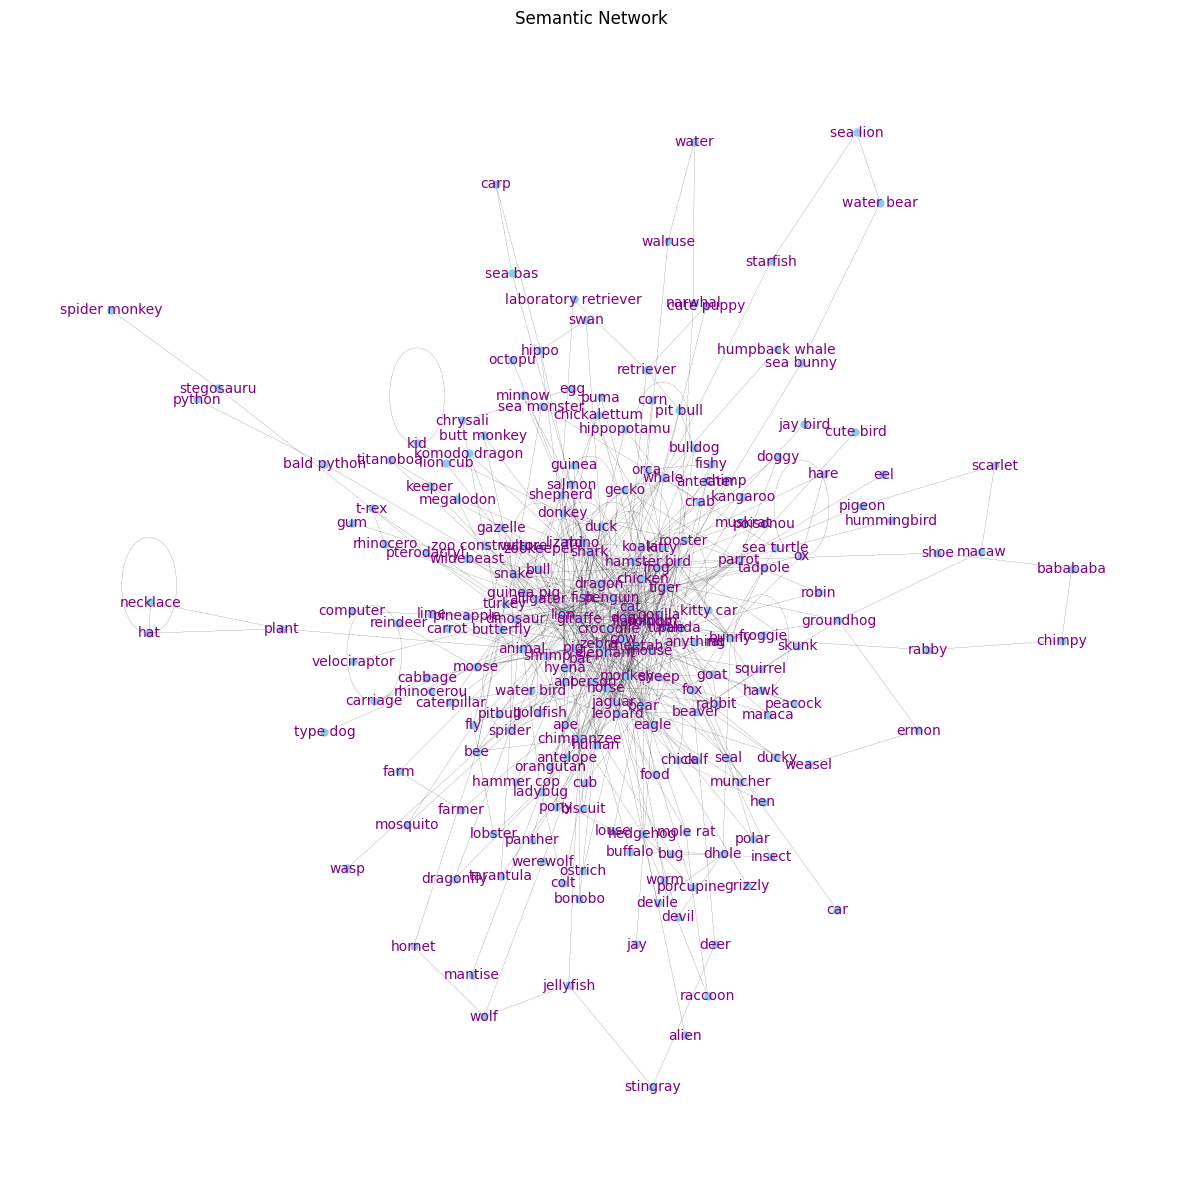

In [ ]:
animals_nrw = naiveRandomWalk(lexplay_animals_s.Xs, numnodes=lexplay_animals_s.groupnumnodes)
nrw_graph(animals_nrw, lexplay_animals_s.groupnumnodes, lexplay_animals_s.groupitems)

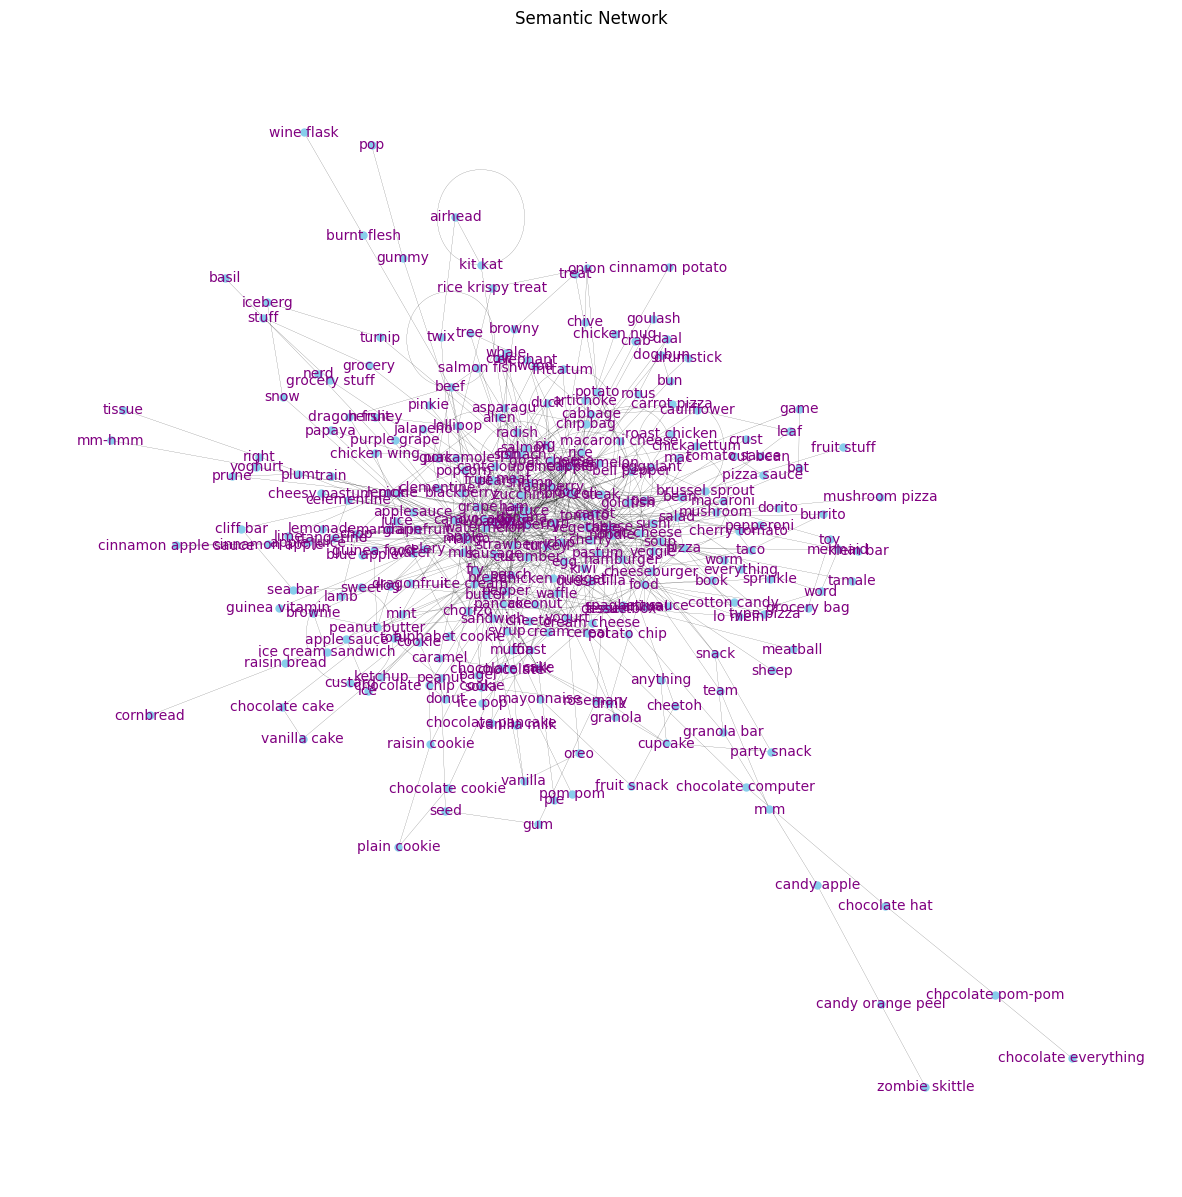

In [ ]:
foods_nrw = naiveRandomWalk(lexplay_foods_s.Xs, numnodes=lexplay_foods_s.groupnumnodes)
nrw_graph(foods_nrw, lexplay_foods_s.groupnumnodes, lexplay_foods_s.groupitems)

## **U-invite** ##

In [ ]:
def stationary(t, method="unweighted"):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    if method=="unweighted":                 # only works for unweighted matrices!
        return sum(t>0)/float(sum(sum(t>0)))
    else:                                       # buggy
        eigen=np.linalg.eig(t)[1][:,0]
        return np.real(eigen/sum(eigen))

In [ ]:
# mix U-INVITE with random jumping model
def addJumps(probs, td, numnodes=None, statdist=None, Xs=None):
    """Adjust transition matrix of network to allow for jumps

        This function takes a network transition matrix and adjusts the transition probabilities from each edge to allow "jumps."

        Args:
            probs (type): Description here.
            td (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    if (td.jumptype == "uniform") and (numnodes == None):
        raise ValueError("Must specify 'numnodes' when jumptype is uniform [addJumps]")
    if (td.jumptype == "stationary") and (np.any(statdist == None) or (Xs == None)):
        raise ValueError("Must specify 'statdist' and 'Xs' when jumptype is stationary [addJumps]")

    if td.jumptype == "uniform":
        jumpprob = float(td.jump)/numnodes                     # uniform jumping

    for l in range(len(probs)):                                # loop through all lists (l)
        for inum, i in enumerate(probs[l][1:]):                # loop through all items (i) excluding first (don't jump to item 1)
            if td.jumptype=="stationary":
                jumpprob = statdist[Xs[l][inum+1]]             # stationary probability jumping
                if np.isnan(jumpprob):                         # if node is disconnected, jumpprob is nan
                    jumpprob = 0.0
            probs[l][inum+1] = jumpprob + (1-td.jump)*i        # else normalize existing probability and add jumping probability
    return probs

In [ ]:
# mix U-INVITE with priming model
# code is confusing...
def adjustPriming(probs, td, Xs):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    for xnum, x in enumerate(Xs[1:]):         # check all items starting with 2nd list
        for inum, i in enumerate(x[:-1]):     # except last item
            if i in Xs[xnum][:-1]:            # is item in previous list? if so, prime next item
                # follow prime with calc_prob_adjacent td.priming, follow RW with calc_prob_adjacent (1-td.priming)
                idx=Xs[xnum].index(i) # index of item in previous list
                if Xs[xnum][idx+1]==Xs[xnum+1][inum+1]:
                    probs[xnum+1][inum+1] = (probs[xnum+1][inum+1] * (1-td.priming)) + td.priming
                else:
                    probs[xnum+1][inum+1] = (probs[xnum+1][inum+1] * (1-td.priming))
    return probs


In [ ]:
def evalGraphPrior(a, prior, undirected=True):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    probs = []
    priordict = prior[0]
    items = prior[1]
    nullprob = priordict['DEFAULTPRIOR']

    for inum, i in enumerate(a):
        for jnum, j in enumerate(i):
            if (inum > jnum) or ((undirected==False) and (inum != jnum)):
                if undirected:
                    pair = np.sort((items[inum], items[jnum]))
                else:
                    pair = (items[inum], items[jnum])
                try:
                    priorprob = priordict[pair[0]][pair[1]]
                    if j==1:
                        prob = priorprob
                    elif j==0:
                        prob = (1-priorprob)
                except:
                    prob = nullprob  #  no information about edge
                probs.append(prob)

    probs = [np.log(prob) for prob in probs]      # multiplication probably results in underflow...
    probs = sum(probs)
    return probs

In [ ]:
class dotdict(dict):
    """
    Example:
    m = dotdict({'first_name': 'Eduardo'}, last_name='Pool', age=24, sports=['Soccer'])
    """
    def __init__(self, *args, **kwargs):
        super(dotdict, self).__init__(*args, **kwargs)
        for arg in args:
            if isinstance(arg, dict):
                for k, v in list(arg.items()):
                    self[k] = v

        if kwargs:
            for k, v in list(kwargs.items()):
                self[k] = v

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__setitem__(key, value)

    def __setitem__(self, key, value):
        super(dotdict, self).__setitem__(key, value)
        self.__dict__.update({key: value})

    def __delattr__(self, item):
        self.__delitem__(item)

    def __delitem__(self, key):
        super(Map, self).__delitem__(key)  # TODO: no definition of Map
        del self.__dict__[key]

In [ ]:
def probX(Xs, a, td, irts=Irts({}), prior=None, origmat=None, changed=[]):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """

    try:
        numnodes=len(a)
    except TypeError:
        raise Exception(a)
    reg=(1+1e-10)                           # nuisance parameter to prevent errors; can also use pinv instead of inv, but that's much slower
    identmat=np.identity(numnodes) * reg    # pre-compute for tiny speed-up (only for non-IRT)

    probs=[]

    # generate transition matrix (from: column, to: row) from link matrix
    t=a/sum(a.astype(float))
    t=np.nan_to_num(t)                  # jumping/priming models can have nan in matrix, need to change to 0

    if (td.jumptype=="stationary") or (td.start_node=="stationary"):
        statdist=stationary(t)

    # U-INVITE probability excluding jumps, prior, and priming adjustments -- those come later
    for xnum, x in enumerate(Xs):
        x2=np.array(x)
        t2=t[x2[:,None],x2]                                        # re-arrange transition matrix to be in list order
        prob=[]
        if td.start_node=="stationary":
            prob.append(statdist[x[0]])                            # probability of X_1
        elif td.start_node=="uniform":
            prob.append(1.0/numnodes)

        # if impossible starting point, return immediately
        if (prob[-1]==0.0):
            try:
                return -np.inf, (x[0], x[1])
            except:
                return -np.inf, x[0]

        if (len(changed) > 0) and isinstance(origmat,list):        # if updating prob. matrix based on specific link changes
            update=0                                               # reset for each list

        # flag if list contains perseverations
        if len(x) == len(set(x)):
            list_has_perseverations = False
        else:
            list_has_perseverations = True

        for curpos in range(1,len(x)):
            if (len(changed) > 0) and isinstance(origmat,list):
                if update==0:                                      # first check if probability needs to be updated
                    if (Xs[xnum][curpos-1] in changed):            # (only AFTER first changed node has been reached)
                        update=1
                    else:                                          # if not, take probability from old matrix
                        prob.append(origmat[xnum][curpos])
                        continue

            if list_has_perseverations:            # a bit slower because matrix is being copied
                x2=np.array([i for i,j in enumerate(x) if (j not in x[:i]) and (i < curpos)]) # column ids for transient states excluding perseverations
                Q=t2[x2[:,None],x2]                # excludes perseverations. could be sped if only performed when Q contains perseverations
                                                   # as opposed to being done for every transition if a perseveration is in the list
            else:
                Q=t2[:curpos,:curpos]              # old way when data does not include perseverations

            # td.censor_fault is necessary to model perservations in the data
            if td.censor_fault > 0.0:
                Q=np.multiply(Q, 1.0-td.censor_fault)

            if len(irts.data) > 0:     # use this method only when passing IRTs
                numcols=len(Q)
                flist=[]
                newQ=np.zeros(numcols)                             # init to Q^0, for when r=1
                newQ[curpos-1]=1.0                                 # (using only one: row for efficiency)

                irt=irts.data[xnum][curpos-1]

                # precompute for small speedup
                if irts.irttype=="gamma":
                    logbeta=np.log(irts.gamma_beta)
                    logirt=np.log(irt)

                # normalize irt probabilities to avoid irt weighting
                if irts.irttype=="gamma":
                     # r=alpha. probability of observing irt at r steps
                    irtdist=[r*logbeta-math.lgamma(r)+(r-1)*logirt-irts.gamma_beta*irt for r in range(1,irts.rcutoff)]
                if irts.irttype=="exgauss":

                    irtdist=[np.log(irts.exgauss_lambda/2.0)+(irts.exgauss_lambda/2.0)*(2.0*r+irts.exgauss_lambda*(irts.exgauss_sigma**2)-2*irt)+np.log(math.erfc((r+irts.exgauss_lambda*(irts.exgauss_sigma**2)-irt)/(np.sqrt(2)*irts.exgauss_sigma))) for r in range(1,irts.rcutoff)]

                for r in range(1,irts.rcutoff):
                    innersum=0
                    for k in range(numcols):
                        num1=newQ[k]                               # probability of being at node k in r-1 steps
                        num2=t2[curpos,k]                          # probability transitioning from k to absorbing node
                        innersum=innersum+(num1*num2)

                    # compute irt probability given r steps
                    log_dist = irtdist[r-1] / sum(irtdist)

                    if innersum > 0: # sometimes it's not possible to get to the target node in r steps
                        flist.append(log_dist + np.log(innersum))

                    newQ=np.inner(newQ,Q)                          # raise power by one

                f=sum([np.e**i for i in flist])
                prob.append(f)                                     # probability of x_(t-1) to X_t
            else:                                                  # if no IRTs, use standard U-INVITE
                I=identmat[:len(Q),:len(Q)]

                # novel items are emitted with probability 1 when encountered. perseverations are emitted with probability td.censor_fault when encountered.
                if list_has_perseverations:              # if list has perseverations. could speed up by only doing this step when a perseveration has been encountered
                    x1=np.array([curpos])   # absorbing node
                    #x2=np.array([i for i,j in enumerate(x) if (j not in x[:i]) and (i < curpos)]) # column ids for transient states excluding perseverations
                    x2=np.array([i for i,j in enumerate(x) if (j not in x[i+1:curpos]) and (i < curpos)]) # column ids for transient states excluding perseverations
                    R=t2[x1[:,None],x2][0]  # why is [0] necessary here but not in the else case?

                    if Xs[xnum][curpos] in Xs[xnum][:curpos]:       # if absorbing state has appeared in list before...
                        R=np.multiply(R,td.censor_fault)
                else:                                       # if not a perseveration
                    R=t2[curpos,:curpos]                    # old way

                ### test (when censor_fault=0) to see if absorbing distribution sums to 1... something is broken
                #total = []
                #x2=np.array([j for i,j in enumerate(x) if (i < curpos)]) # column ids for transient states excluding perseverations
                #N=np.linalg.solve(I-Q,I[-1])
                #for i in range(len(t)):
                #    R=t[np.array([i])[:,None],x2]
                #    B=np.dot(R,N)
                #    total.append(B[0])
                #    if B[0] > 1.0:
                #        print("NONONO")
                #print("total ", total)
                #R=t2[curpos,:curpos]                    # old way to reset
                ###

                N=np.linalg.solve(I-Q,I[-1])
                B=np.dot(R,N)
                if np.isnan(B):
                    B=0.0
                prob.append(B)

                # alternative/original using matrix inverse
                #R=t2[curpos:,:curpos]
                #N=inv(I-Q)
                #B=np.dot(R,N)
                #prob.append(B[0,curpos-1])

            # if there's an impossible transition and no jumping/priming, return immediately
            if (prob[-1]==0.0) and (td.jump == 0.0) and (td.priming == 0.0):
                return -np.inf, (x[curpos-1], x[curpos])

        probs.append(prob)

    uinvite_probs = copy.deepcopy(probs)      # store only u-invite transition probabilities (the computationally hard stuff) to avoid recomputing

    # adjust for jumping probability
    if td.jump > 0.0:
        if td.jumptype=="uniform":
            probs=addJumps(probs, td, numnodes=numnodes)
        elif td.jumptype=="stationary":
            probs=addJumps(probs, td, statdist=statdist, Xs=Xs)

    if (td.priming > 0.0):
        probs=adjustPriming(probs, td, Xs)

    # check for impossible transitions after priming and jumping
    for xnum, x in enumerate(probs):
        for inum, i in enumerate(x):
            if (i==0.0) and (inum==0):
                return -np.inf, (Xs[xnum][inum], Xs[xnum][inum+1])  # link to next item when first item is unreachable
            elif (i==0.0) and (inum > 0):
                return -np.inf, (Xs[xnum][inum-1], Xs[xnum][inum])  # link to previous item otherwise

    try:
        ll=sum([sum([np.log(j) for j in probs[i]]) for i in range(len(probs))])
    except:
        ll=-np.inf

    # include prior?
    if prior:
        priorlogprob = evalGraphPrior(a, prior)
        ll = ll + priorlogprob

    return ll, uinvite_probs


In [ ]:
# generate starting graph for U-INVITE
def genStartGraph(Xs, numnodes, td, fitinfo):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    if fitinfo.startGraph=="cn_valid":
        graph = conceptualNetwork(Xs, numnodes, td=td, valid=True, fitinfo=fitinfo)
    elif fitinfo.startGraph=="pf_valid":
        graph = pathfinder(Xs, numnodes, valid=True, td=td)
    elif (fitinfo.startGraph=="rw" or fitinfo.startGraph=="nrw"):
        graph = naiveRandomWalk(Xs,numnodes)
    elif fitinfo.startGraph=="fully_connected":
        graph = fullyConnected(numnodes)
    elif fitinfo.startGraph=="empty_graph":
        graph = np.zeros((numnodes,numnodes)).astype(int)           # useless...
    else:
        graph = np.copy(fitinfo.startGraph)                         # assume a graph has been passed as a starting point
    return graph


In [ ]:
def uinvite(Xs, td=DataModel({}), numnodes=None, irts=Irts({}), fitinfo=Fitinfo({}), prior=None, debug=True, seed=None):
    """One line description here.

        Detailed description here. Detailed description here.  Detailed
        description here.

        Args:
            arg1 (type): Description here.
            arg2 (type): Description here.
        Returns:
            Detailed description here. Detailed description here.  Detailed
            description here.
    """
    nplocal=np.random.RandomState(seed)

    if numnodes == None:
        numnodes = len(set(flatten_list(Xs)))

    # return list of neighbors of neighbors of i, that aren't themselves neighbors of i
    # i.e., an edge between i and any item in nn forms a triangle
    def neighborsofneighbors(i, nxg):
        nn=[]                                       # neighbors of neighbors (nn)
        n=list(nx.all_neighbors(nxg,i))
        for j in n:
            nn=nn+list(nx.all_neighbors(nxg,j))
        nn=list(set(nn))
        for k in n:                                 # remove neighbors
            if k in nn:
                nn.remove(k)
        if i in nn:
            nn.remove(i)                            # remove self
        return nn

    # toggle links back, should be faster than making graph copy
    def swapEdges(graph,links):
        for link in links:
            graph[link[0],link[1]] = 1 - graph[link[0],link[1]]
            if not fitinfo.directed:
                graph[link[1],link[0]] = 1 - graph[link[1],link[0]]
        return graph

    def pivot(graph, vmin=1, vmaj=0, best_ll=None, probmat=None, limit=np.inf, method=""):
        numchanges=0     # number of changes in single pivot() call

        if (best_ll == None) or (np.any(probmat == None)):
            best_ll, probmat = probX(Xs,graph,td,irts=irts,prior=prior)   # LL of best graph found
        nxg=nx.to_networkx_graph(graph)

        # generate dict where v[i] is a list of nodes where (i, v[i]) is an existing edge in the graph
        if (method=="prune") or (method==0):
            if debug:
                print("Pruning", str(vmaj) + "." + str(vmin), "... ",) # (len(edges)/2)-len(firstedges), "possible:",
            sys.stdout.flush()
            listofedges=np.where(graph==1)
            v=dict()
            for i in range(numnodes):
                v[i]=[]
            for i in zip(*listofedges):
                  if td.jump == 0.0:                                                      # unless jumping is allowed, untested 10/6/17 JCZ
                      v[i[0]].append(i[1])

        # generate dict where v[i] is a list of nodes where (i, v[i]) would form a new triangle
        if (method=="triangles") or (method==1):
            if debug:
                print("Adding triangles", str(vmaj) + "." + str(vmin), "... ",) # (len(edges)/2), "possible:",
            sys.stdout.flush()
            nn=dict()
            for i in range(len(graph)):
                nn[i]=neighborsofneighbors(i, nxg)
            v=nn

        # generate dict where v[i] is a list of nodes where (i, v[i]) is NOT an existing an edge and does NOT form a triangle
        if (method=="nonneighbors") or (method==2):
            # list of a node's non-neighbors (non-edges) that don't form triangles
            if debug:
                print("Adding other edges", str(vmaj) + "." + str(vmin), "... ",)
            sys.stdout.flush()
            nonneighbors=dict()
            for i in range(numnodes):
                nn=neighborsofneighbors(i, nxg)
                # non-neighbors that DON'T form triangles
                nonneighbors[i]=[j for j in range(numnodes) if j not in nx.all_neighbors(nxg,i) and j not in nn]
                if i in nonneighbors[i]: nonneighbors[i].remove(i) # also remove self
            v=nonneighbors

        count=[0.0]*numnodes
        avg=[-np.inf]*numnodes
        finishednodes=0
        loopcount=0

        while (finishednodes < numnodes) and (loopcount < limit):
            loopcount += 1          # number of failures before giving up on this pahse
            maxval=max(avg)
            bestnodes=[i for i, j in enumerate(avg) if j == maxval]  # most promising nodes based on avg logprob of edges with each node as vertex
            node1=nplocal.choice(bestnodes)

            if len(v[node1]) > 0:
                #node2=nplocal.choice(v[node1]) # old

                n2avg=[avg[i] for i in v[node1]]
                maxval=max(n2avg)
                bestnodes=[v[node1][i] for i, j in enumerate(n2avg) if j == maxval]
                node2=nplocal.choice(bestnodes)

                edge=(node1, node2)
                graph=swapEdges(graph,[edge])

                graph_ll, newprobmat=probX(Xs,graph,td,irts=irts,prior=prior,origmat=probmat,changed=[node1,node2])

                if best_ll >= graph_ll:
                    graph=swapEdges(graph,[edge])
                else:
                    best_ll = graph_ll
                    probmat = newprobmat
                    numchanges += 1
                    loopcount = 0
                    # probX under all possible perseveration values JCZ 5/9/2018
                    if fitinfo.estimatePerseveration:
                        old_censor = td.censor_fault
                        best_param = old_censor
                        for censor_param in [i/100.0 for i in range(101)]:
                            td.censor_fault = censor_param
                            graph_ll, newprobmat = probX(Xs,graph,td,irts=irts,prior=prior)   # LL of starting graph
                            if graph_ll > best_ll:
                                best_ll = graph_ll
                                probmat = newprobmat
                                best_param = censor_param
                        td.censor_fault = best_param
                        if debug:
                            print("censor_fault old:", old_censor, " censor_fault new: ", best_param)

                v[node1].remove(node2)   # remove edge from possible choices
                if not fitinfo.directed and node1 in v[node2]:
                    v[node2].remove(node1)

                # increment even if graph prob = -np.inf for implicit penalty
                count[node1] += 1
                count[node2] += 1
                if (graph_ll != -np.inf) and (fitinfo.followtype != "random"):
                    if avg[node1] == -np.inf:
                        avg[node1] = graph_ll
                    else: # followtype == avg
                            avg[node1] = avg[node1] * ((count[node1]-1)/count[node1]) + (1.0/count[node1]) * graph_ll
                    if avg[node2] == -np.inf:
                        avg[node2] = graph_ll
                    else:  # followtype == avg
                        avg[node2] = avg[node2] * ((count[node2]-1)/count[node2]) + (1.0/count[node2]) * graph_ll
            else:                       # no edges on this node left to try!
                avg[node1]=-np.inf      # so we don't try it again...
                finishednodes += 1

        if debug:
            print(numchanges, "changes")

        return graph, best_ll, probmat, numchanges

    #    return graph

    def phases(graph, best_ll, probmat):
        complete=[0,0,0]         # marks which phases are complete
        vmaj=0
        vmin=1
        while sum(complete) < 3:
            phasenum=complete.index(0)
            if phasenum==0: limit=fitinfo.prune_limit
            if phasenum==1: limit=fitinfo.triangle_limit
            if phasenum==2: limit=fitinfo.other_limit
            if (phasenum==0) and (vmin==1): vmaj += 1

            graph, best_ll, probmat, numchanges = pivot(graph, best_ll=best_ll, vmaj=vmaj, vmin=vmin, method=phasenum, limit=limit, probmat=probmat)
            if numchanges > 0:
                vmin += 1
            else:
                if (vmin==1): complete[phasenum]=1
                if (phasenum==0) and (vmin>1): complete=[1,0,0]
                if (phasenum==1) and (vmin>1): complete=[0,1,0]
                if (phasenum==2) and (vmin>1): complete=[0,0,1]
                vmin=1
        return graph, best_ll

    # check if data has perseverations
    '''if not [len(set(i)) for i in Xs]==[len(i) for i in Xs]:
        if (td.censor_fault == 0.0) and (not fitinfo.estimatePerseveration):
            raise Exception(''''''Your data contains perseverations, but \
                            censor_fault = 0.0; Set to some value 0.0 < x <= 1.0 or
                            set estimatePerseveration to True'''''')

    try:
        firstedges=[(x[0], x[1]) for x in Xs]
    except:
        firstedges=[]'''

    # find a good starting graph
    graph = genStartGraph(Xs, numnodes, td, fitinfo)

    # find best starting perseveration parameter if applicable JCZ 5/9/2018
    if fitinfo.estimatePerseveration:
        best_ll = -np.inf
        best_param = 0.0
        for censor_param in [i/100.0 for i in range(101)]:
            td.censor_fault = censor_param
            graph_ll, probmat = probX(Xs,graph,td,irts=irts,prior=prior)   # LL of starting graph
            if graph_ll > best_ll:
                best_ll = graph_ll
                best_param = censor_param
        td.censor_fault = best_param

    best_ll, probmat = probX(Xs,graph,td,irts=irts,prior=prior)   # LL of starting graph
    graph, best_ll = phases(graph, best_ll, probmat)

    return graph, best_ll

In [ ]:
datamodel = DataModel({
        'jump': 0.0,                        # The censored random walk should jump to a new node with what probability?
        'jumptype': "stationary",           # When jumping, should it jump to a new node with 'uniform' probability or according to the 'stationary' distribution?
        'start_node': "stationary",         # Is the start node in each list chosen with 'uniform' probability or according to the 'stationary' distribution?
        'priming': 0.0,                     # Accounts for increased bi-gram probability in repeated fluency task. See Zemla & Austerweil (2017; cogsci proceeeding)
        'censor_fault': 0.0                 # Repeated nodes are typically censore with probability 1, but can be emitted with some fixed probability
})

In [ ]:
fitinfo = Fitinfo({
        # U-INVIE needs to be initialized. A modified ConceptualNetwork (see Zemla
        # & Austerweil, 2018) is a reasonable choice, but you can also use
        # NaiveRandomWalk ('nrw'), modified Pathfinder ('pf_valid') or a
        # 'fully_connected' network
        'startGraph': "nrw",

        'directed': False,                  # U-INVITE can fit directed networks, though it hasn't been tested extensively

        # Parameters for the ConceptualNetwork initialization, or when fitting ConceptualNetworks in their own right
        #'cn_alpha': 0.05,                   # p-value for deciding if two nodes occur together more than chance. Goni et al (2011) Table 1 \alpha
        #'cn_windowsize': 2,                 # Do two items in a list co-occur? See Goni et al (2011) Fig 1
        #'cn_threshold': 2,                  # At least this many co-occurrences to add an edge. See Goni et al (2011) Table 1 'Hits'

        # U-INVITE will toggle edges in a network to see if the data are more
        # likely under that new network. When set to np.inf, it will
        # exhaustively toggle all edges. Because U-INVITE prioritizes togling
        # edges that are likely to affect the maximum-likelihood solution, you
        # can drastically cut down on compute time by setting a threshold.
        # These thresholds indicate how many edges to toggle in each phase
        # before moving on. See Zemla & Austerweil (2018) and its appendix.
        'prune_limit': 100,                 # ...when trying to remove nodes
        'triangle_limit': 100,              # ...when trying to add edges that form network triangles
        'other_limit': 100,                 # ...when trying to add edges that do not form triangles

        # When using a prior, how is the prior probability of each edge determined from the given prior networks?
        # See Zemla & Austerweil (2018) for more detail (ZA2018)

        # when using ZIBB, affects proportion of non-observed non-edges (ZA2018
        # Eq. 15 "p_hidden"). when set to 0.0, it becomes the beta-binomial
        # (not zero-inflated). this trio of parameters sets the prior
        # probability of an edge to 0.5 when no other info is known about that
        # edge.
        'zibb_p': 0.5,
        'prior_b': 1,                                 # affects probability of edge when no knowledge of edge exists (ZA2018 Eq. 16 "\beta_0")
        'prior_a': 2,                                 # affects probability of non-edge when no knowledge of edge exists (ZA2018 Eq. 15 "\alpha_0")

        # Instead of specifying a fixed censor_fault in the data model, you can
        # estimate the best fit parameter using maximum-likelihood and grid
        # search
        'estimatePerseveration': True
        })

In [ ]:
# Estimate the best network using a non-hierarchical U-INVITE for the first subject only
def example1():
    uinvite_network, ll = uinvite(lexplay_animals_s.Xs,    # provide fluency lists
                                      datamodel,                # specify data model
                                      fitinfo=fitinfo,          # specify fit info
                                      debug=True,
                                      numnodes=lexplay_animals_s.groupnumnodes)               # suppress print output to console when set to False
    return uinvite_network

In [ ]:
animal_network = example1()

Pruning 1.1 ... 


<ipython-input-231-a76c1ba0ad31>:25: RuntimeWarning: invalid value encountered in divide
  t=a/sum(a.astype(float))


0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes


In [ ]:
def uinvite_graph(a, numnodes, groupitems):

  # Create a graph for visualization
  G_semantic = nx.Graph()

  for i in range(numnodes):
    for j in range(numnodes):
      if a[i][j] == 1:
        G_semantic.add_node(groupitems[i])
        G_semantic.add_node(groupitems[j])
        G_semantic.add_edge(groupitems[i], groupitems[j], weight=1)

  pos = nx.spring_layout(G_semantic)
  edge_labels = {(u, v): d['weight'] for u, v, d in G_semantic.edges(data=True)}

  plt.figure(figsize=(15, 15))
  nx.draw_networkx_nodes(G_semantic, pos, node_size=25, node_color='skyblue')
  nx.draw_networkx_labels(G_semantic, pos, font_size=10, font_color='purple')
  nx.draw_networkx_edges(G_semantic, pos, edgelist=G_semantic.edges(), width=[d['weight'] / 10 for u, v, d in G_semantic.edges(data=True)])
  #nx.draw_networkx_edge_labels(G_semantic, pos, edge_labels=edge_labels, font_size=8)
  plt.axis('off')
  plt.title('Semantic Network')
  plt.show()

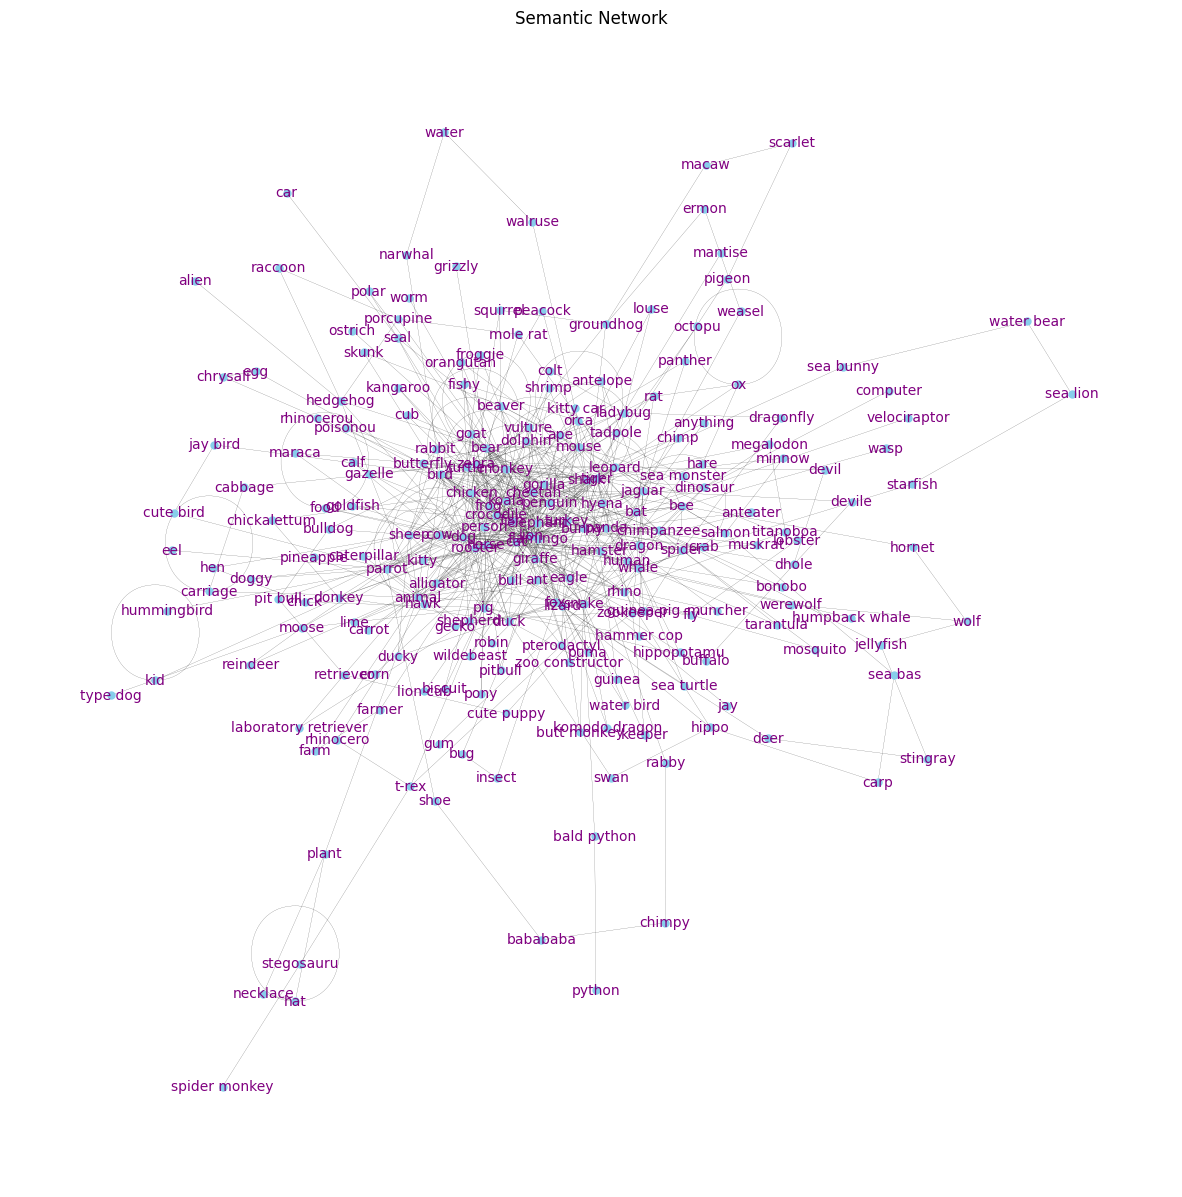

In [ ]:
uinvite_graph(animal_network, lexplay_animals_s.groupnumnodes, lexplay_animals_s.groupitems)

In [ ]:
uinvite_network, ll = uinvite([lexplay_animals_s.Xs[0], lexplay_animals_s.Xs[1]],    # provide fluency lists
                                      datamodel,                # specify data model
                                      fitinfo=fitinfo,          # specify fit info
                                      debug=True,
                                      numnodes=lexplay_animals_s.groupnumnodes)               # suppress print output to console when set to False


<ipython-input-231-a76c1ba0ad31>:25: RuntimeWarning: invalid value encountered in divide
  t=a/sum(a.astype(float))


Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes


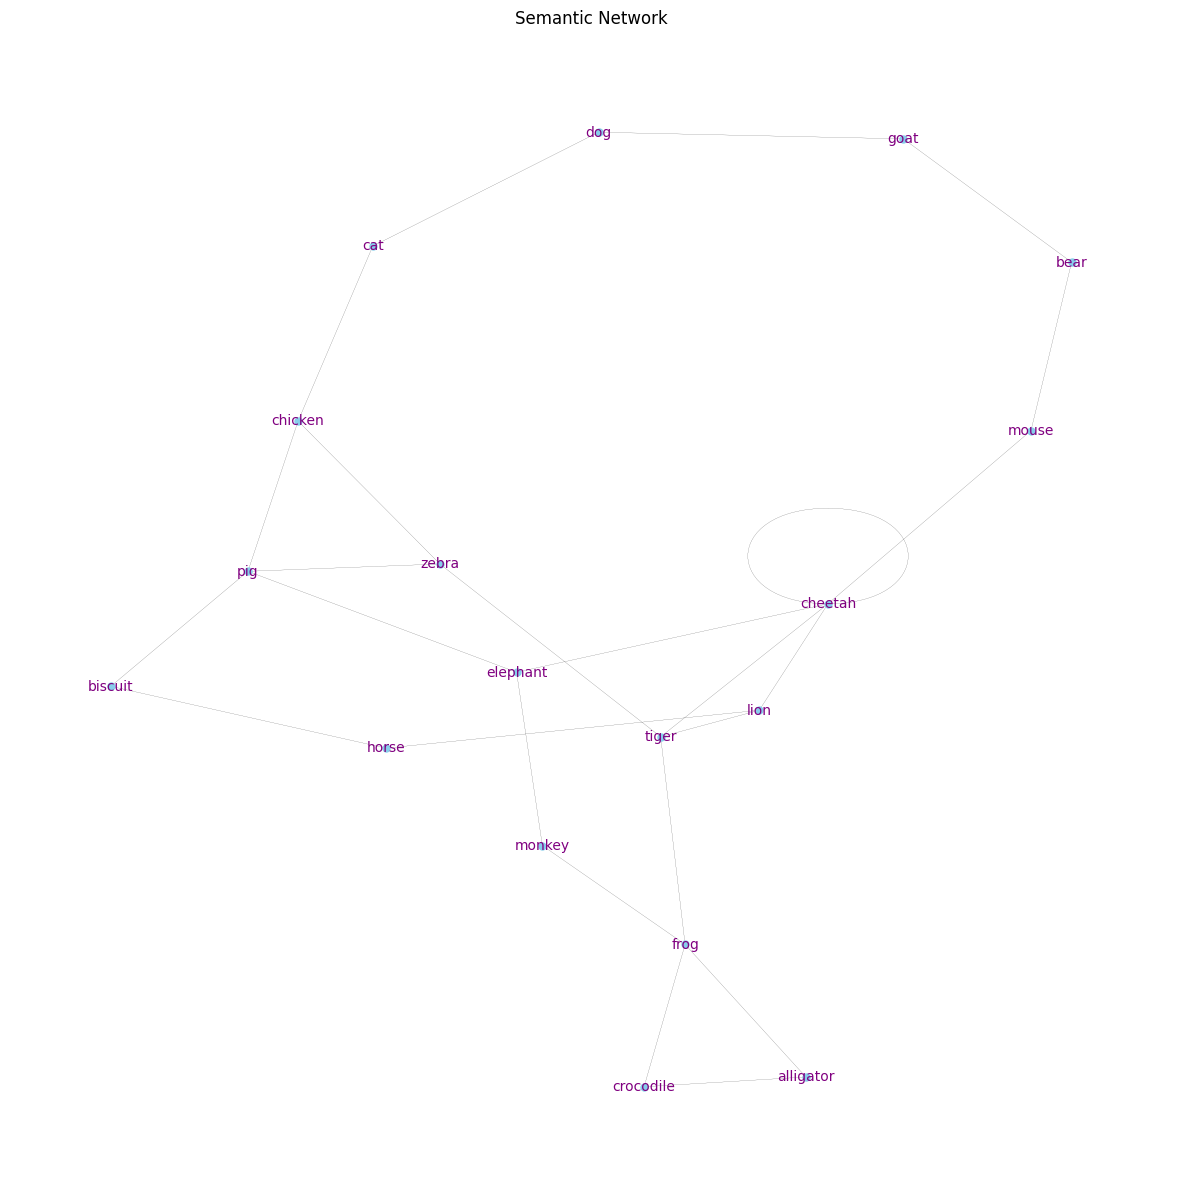

In [ ]:
uinvite_graph(uinvite_network, lexplay_animals_s.groupnumnodes, lexplay_animals_s.groupitems)

## **An NLP technique using word embeddings to get similarity scores** ##

**I'm calling it: Euclidean Similarity Network**

Necessary steps (courtesy of Chat-GPT):

1. Prepare Data: You need fluency list data, and you'll need pre-trained word embeddings. You can use popular embeddings like Word2Vec, GloVe, or FastText.

2. Load Pre-trained Word Embeddings: Load the pre-trained word embeddings model. You can use libraries like Gensim for Word2Vec or spaCy for GloVe.

3. Compute Word Embeddings for Fluency Lists: For each word in your fluency lists, compute its word embedding vector using the pre-trained model.

4. Define a Similarity Metric: Define a similarity metric to measure the similarity between word vectors. Common similarity metrics include cosine similarity or Euclidean distance. You can use libraries like Scikit-learn or NumPy for these calculations.

5. Build the Semantic Network: Create a network (e.g., a graph) where words are nodes, and the edges between words represent the similarity between their embeddings based on your chosen metric.

One issue/source of inaccuracy: not every utterance is present in the embeddings vocabulary (kids are creative!)

In [ ]:
# run this if need to, but recommend just downloading the 300d file to make it quicker
''' !wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip '''

' !wget http://nlp.stanford.edu/data/glove.6B.zip\n!unzip -q glove.6B.zip '

In [ ]:
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), ".keras/datasets/glove.6B.100d.txt"
)

embeddings_index = {}
with open('/content/drive/MyDrive/Annie Senior Thesis/Results, Semantic Network Models/glove.6B.300d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# mean of distribution of similarity scores is around 0.2... so I set it to that
def euclidean_similarity_network(fluency_lists, embeddings_index, similarity_threshold=0.33):
  # Load pre-trained Word2Vec embeddings (you can use other embeddings like GloVe or FastText)
  model = embeddings_index

  # Create a semantic network
  G = nx.Graph()

  # Define a similarity metric (cosine similarity)
  def similarity(word1, word2):
      try:
          vec1 = model[word1]
          vec2 = model[word2]
          return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
      except KeyError:
          return 0  # Return 0 for words not in the vocabulary

  # Add words as nodes and edges based on similarity
  similarities = []
  for word_list in fluency_lists:
      for word1 in word_list:
          if (word1 not in G) & (word1 in embeddings_index):
              G.add_node(word1)
          for word2 in word_list:
              if (word2 not in G) & (word2 in embeddings_index):
                  G.add_node(word2)
              if word1 != word2:
                  similarity_score = similarity(word1, word2)
                  similarities.append(similarity_score)
                  if similarity_score > similarity_threshold:  # Adjust the threshold as needed
                      G.add_edge(word1, word2, weight=1)


  # Optional: Filter out weak connections
  threshold = 0  # Adjust the threshold as needed
  edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] <= threshold]
  G.remove_edges_from(edges_to_remove)
  return G#, similarities

  # Now, G is the semantic network based on word embeddings and similarity metric

In [ ]:
def esn_graph(G):

  # Create a graph for visualization
  G_semantic = nx.Graph(G)

  pos = nx.spring_layout(G_semantic)
  edge_labels = {(u, v): d['weight'] for u, v, d in G_semantic.edges(data=True)}

  plt.figure(figsize=(15, 15))
  nx.draw_networkx_nodes(G_semantic, pos, node_size=25, node_color='skyblue')
  nx.draw_networkx_labels(G_semantic, pos, font_size=10, font_color='purple')
  nx.draw_networkx_edges(G_semantic, pos, edgelist=G_semantic.edges(), width=[d['weight'] / 10 for u, v, d in G_semantic.edges(data=True)])
  #nx.draw_networkx_edge_labels(G_semantic, pos, edge_labels=edge_labels, font_size=8)
  plt.axis('off')
  plt.title('Semantic Network')
  plt.show()

In [ ]:
relevant_ids, toy_lists, animal_lists, food_lists, zoo_lists, grocery_lists = get_fluency_lists(df, age_year, age_mos)

In [ ]:
animal_lists_s = simplify_lists(animal_lists)
food_lists_s = simplify_lists(food_lists)

In [ ]:
len(food_lists_s)

78

In [ ]:
#g, s = euclidean_similarity_network(food_lists_s, embeddings_index)

In [ ]:
#np.mean(s)

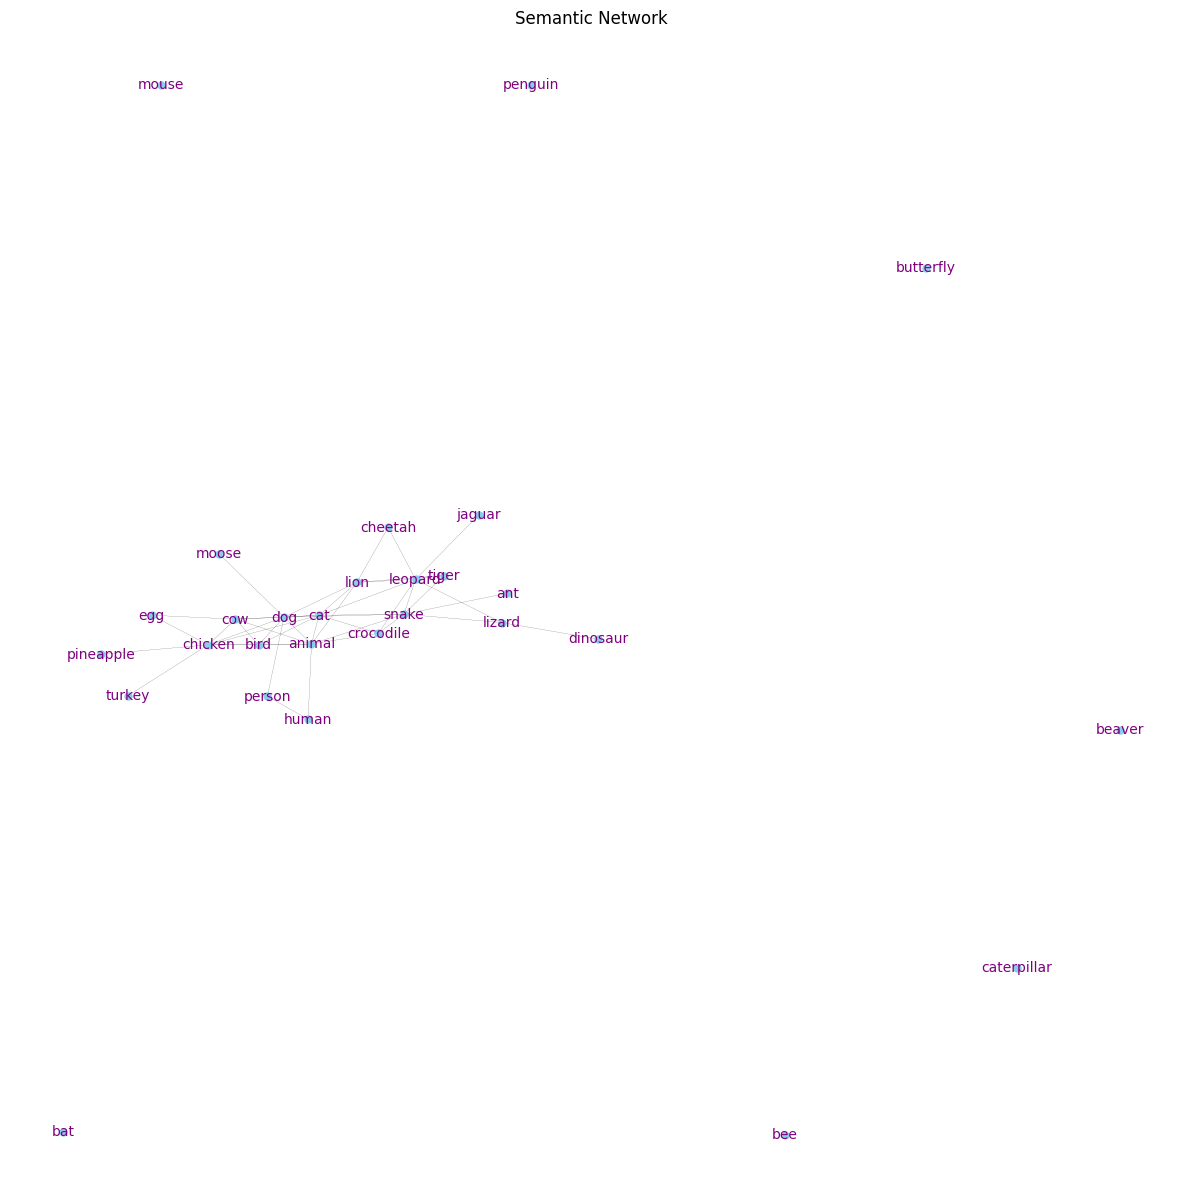

In [ ]:
esn_graph(euclidean_similarity_network(animal_lists_s[0:2], embeddings_index))

In [ ]:
len(animal_lists_s)

78

In [ ]:
# visualize network
def graph(G):
    # Remove nodes with no edges
    nodes_with_edges = [node for node, degree in G.degree() if degree > 0]
    G_semantic_filtered = G.subgraph(nodes_with_edges)

    # Create a graph for visualization
    G_semantic = nx.Graph(G_semantic_filtered)

    pos = nx.spring_layout(G_semantic)
    edge_labels = {(u, v): d['weight'] for u, v, d in G_semantic.edges(data=True)}

    plt.figure(figsize=(15, 15))
    nx.draw_networkx_nodes(G_semantic, pos, node_size=25, node_color='skyblue')
    nx.draw_networkx_labels(G_semantic, pos, font_size=10, font_color='purple')
    nx.draw_networkx_edges(G_semantic, pos, edgelist=G_semantic.edges(), width=[d['weight'] / 10 for u, v, d in G_semantic.edges(data=True)])
    # nx.draw_networkx_edge_labels(G_semantic, pos, edge_labels=edge_labels, font_size=8)
    plt.axis('off')
    plt.title('Semantic Network')
    plt.show()

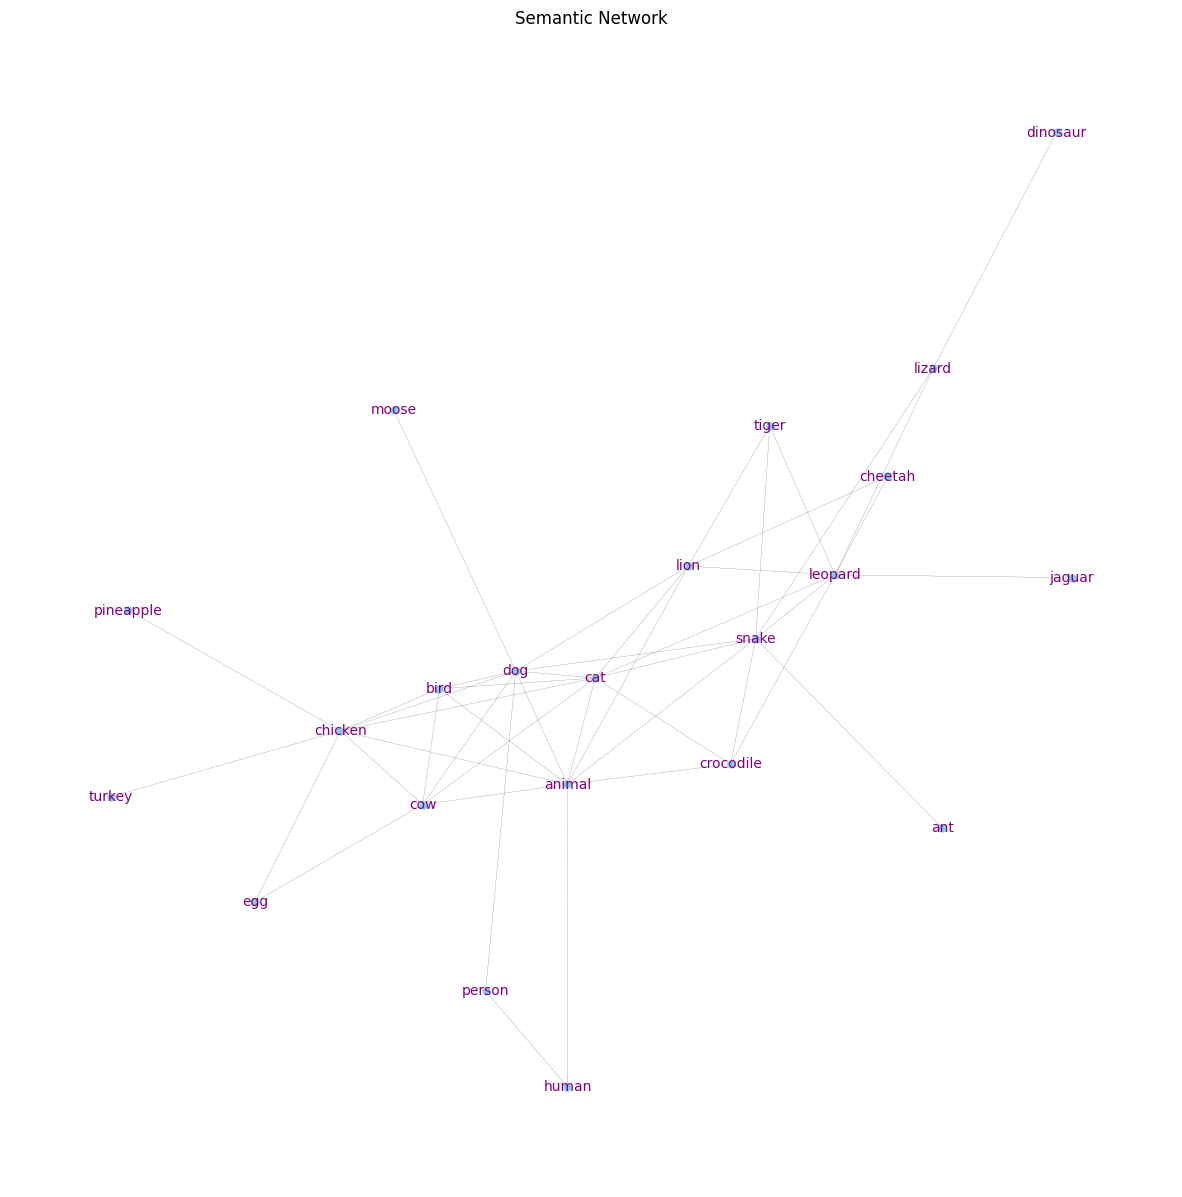

In [ ]:
graph(euclidean_similarity_network(animal_lists_s[0:2], embeddings_index))

## **Network Metrics** ##

Visualizing Clustering Coefficient, Average Shortest Path Length, and highest degree nodes for networks at the group and individual level

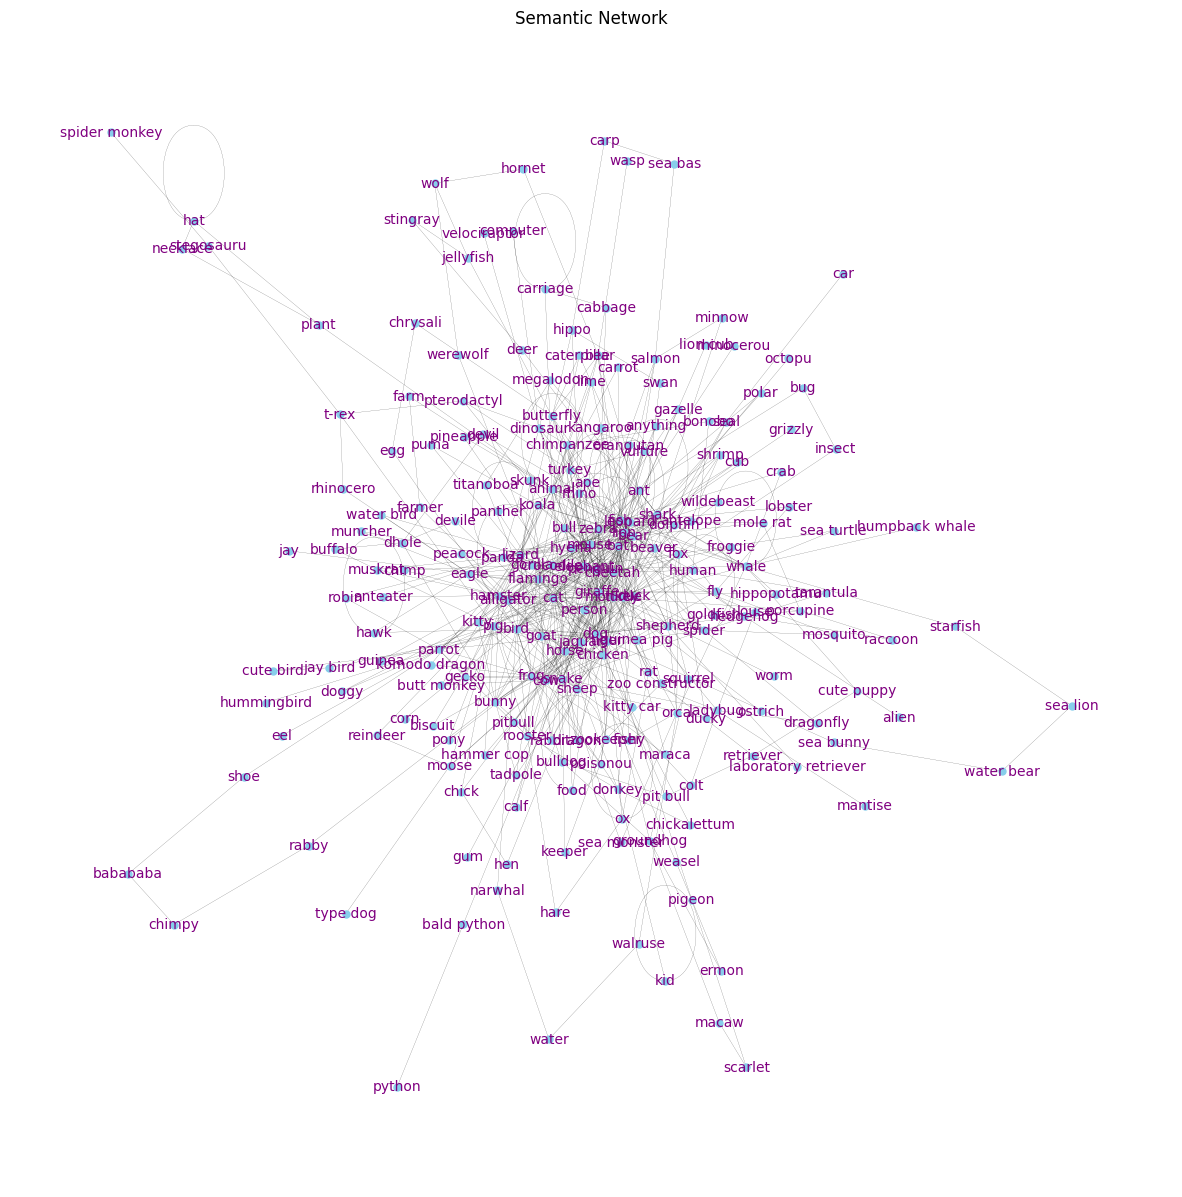

In [ ]:
# get nrw network

this = naiveRandomWalk(lexplay_animals_s.Xs, numnodes=lexplay_animals_s.groupnumnodes)

def nrw_g(a, numnodes, groupitems):

  # Create a graph for visualization
  G_semantic = nx.Graph()

  for i in range(numnodes):
    for j in range(numnodes):
      if a[i][j] == 1:
        G_semantic.add_node(groupitems[i])
        G_semantic.add_node(groupitems[j])
        G_semantic.add_edge(groupitems[i], groupitems[j], weight=1)

  pos = nx.spring_layout(G_semantic)
  edge_labels = {(u, v): d['weight'] for u, v, d in G_semantic.edges(data=True)}
  return G_semantic

nrw_G = nrw_g(this, lexplay_animals_s.groupnumnodes, lexplay_animals_s.groupitems)

graph(nrw_G)

In [ ]:
# get u-invite network
def uinvite_g(a, numnodes, groupitems):

  # Create a graph for visualization
  G_semantic = nx.Graph()

  for i in range(numnodes):
    for j in range(numnodes):
      if a[i][j] == 1:
        G_semantic.add_node(groupitems[i])
        G_semantic.add_node(groupitems[j])
        G_semantic.add_edge(groupitems[i], groupitems[j], weight=1)

  pos = nx.spring_layout(G_semantic)
  edge_labels = {(u, v): d['weight'] for u, v, d in G_semantic.edges(data=True)}
  return G_semantic

uinvite_network, ll = uinvite(lexplay_animals_s.Xs,    # provide fluency lists
                                      datamodel,                # specify data model
                                      fitinfo=fitinfo,          # specify fit info
                                      debug=True,
                                      numnodes=lexplay_animals_s.groupnumnodes)               # suppress print output to console when set to False

u_G = uinvite_g(uinvite_network, lexplay_animals_s.groupnumnodes, lexplay_animals_s.groupitems)

Pruning 1.1 ... 


<ipython-input-231-a76c1ba0ad31>:25: RuntimeWarning: invalid value encountered in divide
  t=a/sum(a.astype(float))


0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes


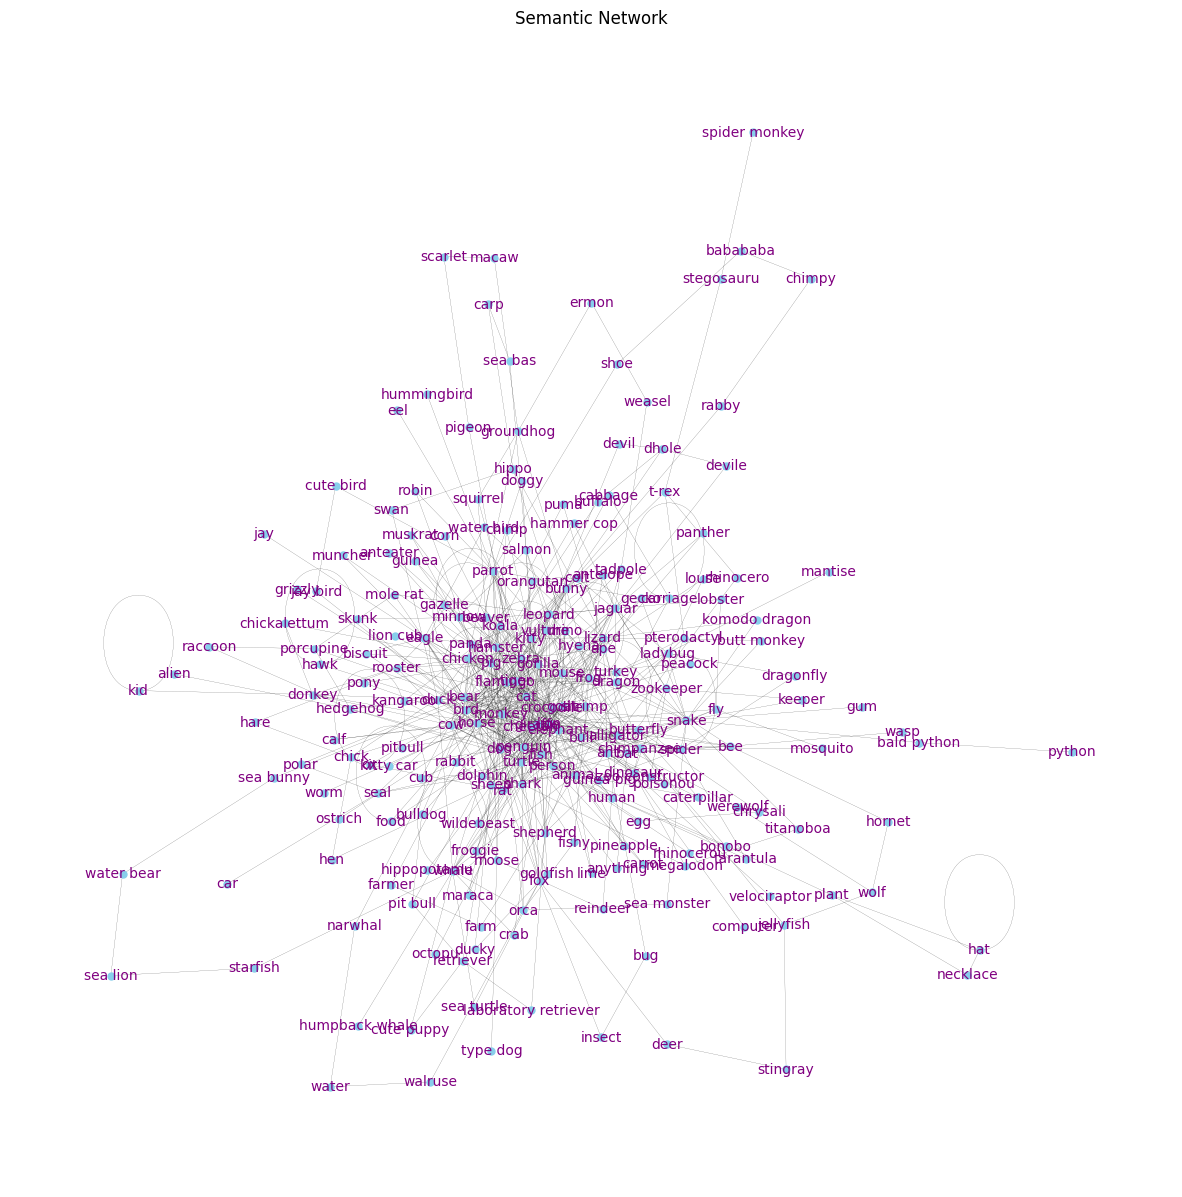

In [ ]:
graph(u_G)

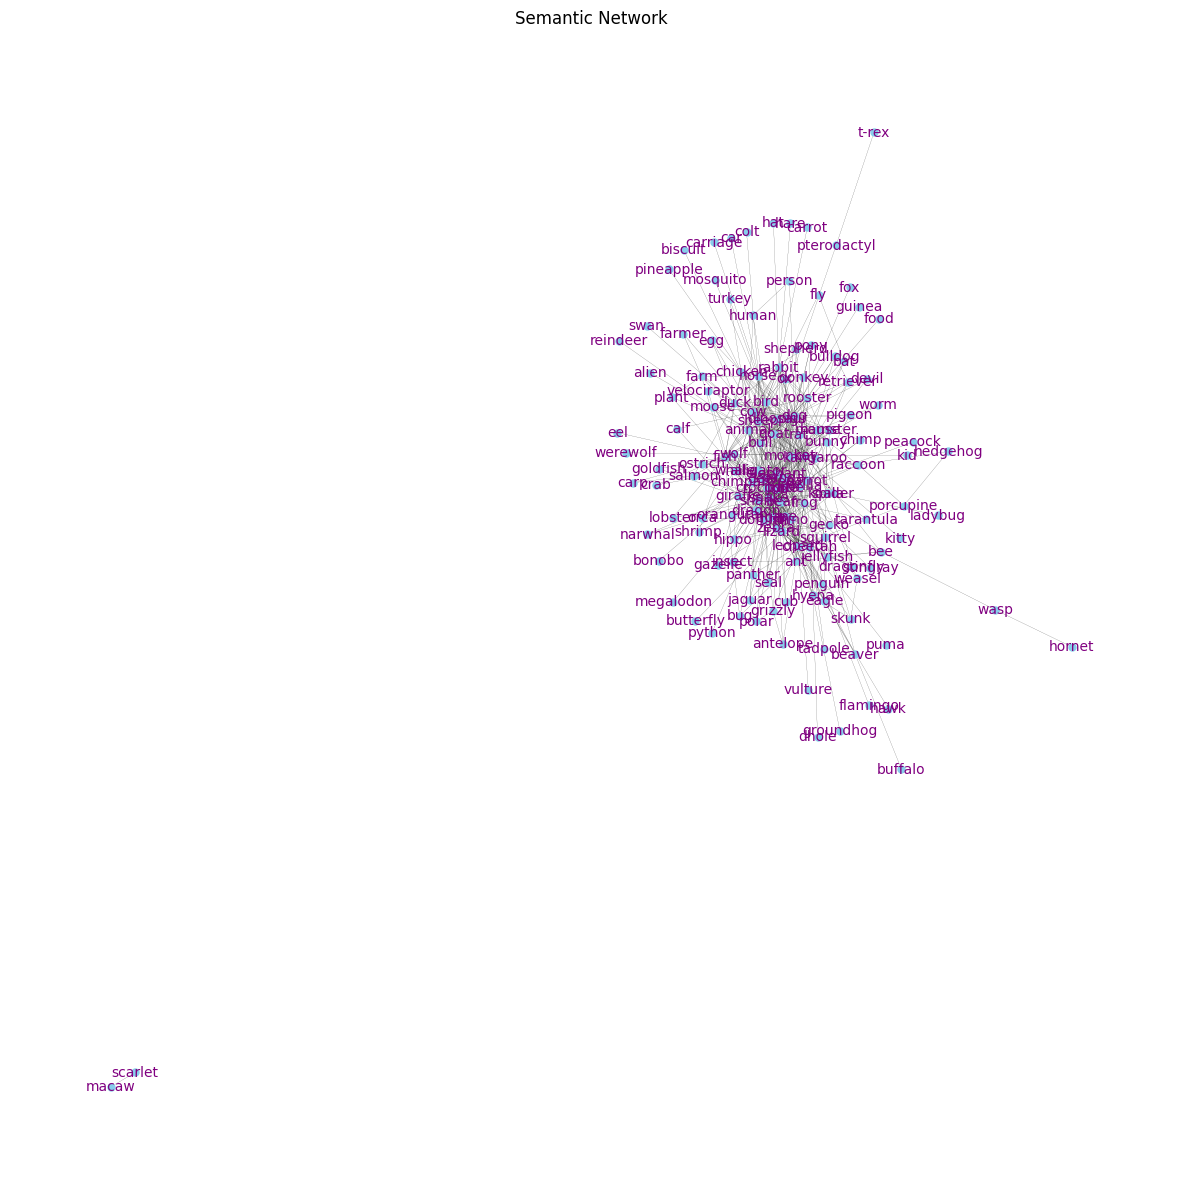

In [ ]:
# get esn network
esn_G = euclidean_similarity_network(animal_lists_s, embeddings_index, similarity_threshold=0.29)
# visualize esn network
graph(esn_G)

In [ ]:
animal_clustering_coefs = [nx.average_clustering(nrw_G), nx.average_clustering(u_G), nx.average_clustering(esn_G)]

In [ ]:
def avg_shortest_path_length(G):
  # Compute the connected components
  connected_components = list(nx.connected_components(G))

  # Compute the average shortest path length for each connected component
  average_shortest_path_lengths = []
  for component in connected_components:
      subgraph = G.subgraph(component)
      if nx.is_connected(subgraph):
        len = nx.average_shortest_path_length(subgraph)
        if len != 0: average_shortest_path_lengths.append(len)
  return np.mean(average_shortest_path_lengths)


animal_path_lengths = [avg_shortest_path_length(nrw_G), avg_shortest_path_length(u_G), avg_shortest_path_length(esn_G)]

In [ ]:
animal_clustering_coefs

[0.19379256548113677, 0.19379256548113677, 0.3568009147596723]

In [ ]:
# find number of nodes, edges, and degrees for animal networks
animal_edge_nums = [nrw_G.number_of_edges(), u_G.number_of_edges(), esn_G.number_of_edges()]

In [ ]:
animal_edge_nums

[681, 681, 682]

In [ ]:
animal_node_nums = [nrw_G.number_of_nodes(), u_G.number_of_nodes(), esn_G.number_of_nodes()]

In [ ]:
animal_node_nums

[219, 219, 178]

In [ ]:
nrw_animal_degrees = sorted(nrw_G.degree, key=lambda x: x[1], reverse=True)

In [ ]:
vals = []
for node, val in nrw_animal_degrees:
  vals.append(val)
np.mean(vals)

6.219178082191781

In [ ]:
ug_animal_degrees = sorted(u_G.degree, key=lambda x: x[1], reverse=True)

In [ ]:
vals = []
for node, val in ug_animal_degrees:
  vals.append(val)
np.mean(vals)

6.219178082191781

In [ ]:
esn_animal_degrees = sorted(esn_G.degree, key=lambda x: x[1], reverse=True)

In [ ]:
vals = []
for node, val in esn_animal_degrees:
  vals.append(val)
np.mean(vals)

7.662921348314606

In [ ]:
nrw_animal_degrees

[('lion', 39),
 ('dog', 34),
 ('monkey', 33),
 ('horse', 33),
 ('cat', 32),
 ('tiger', 30),
 ('giraffe', 30),
 ('zebra', 27),
 ('fish', 27),
 ('bird', 25),
 ('penguin', 25),
 ('bear', 25),
 ('cheetah', 24),
 ('shark', 22),
 ('elephant', 22),
 ('turtle', 22),
 ('snake', 22),
 ('pig', 21),
 ('crocodile', 20),
 ('animal', 20),
 ('cow', 18),
 ('lizard', 17),
 ('chicken', 17),
 ('parrot', 17),
 ('leopard', 16),
 ('jaguar', 16),
 ('panda', 16),
 ('frog', 16),
 ('mouse', 16),
 ('whale', 16),
 ('sheep', 15),
 ('flamingo', 13),
 ('bunny', 13),
 ('alligator', 13),
 ('hamster', 13),
 ('gorilla', 12),
 ('eagle', 12),
 ('fox', 11),
 ('spider', 11),
 ('chimpanzee', 11),
 ('dinosaur', 10),
 ('bat', 10),
 ('ant', 10),
 ('dolphin', 9),
 ('duck', 9),
 ('koala', 8),
 ('bee', 8),
 ('ape', 8),
 ('rooster', 8),
 ('goat', 8),
 ('human', 7),
 ('rhino', 7),
 ('person', 7),
 ('bull', 7),
 ('shepherd', 7),
 ('kitty', 7),
 ('ladybug', 7),
 ('orca', 7),
 ('beaver', 6),
 ('hyena', 6),
 ('butterfly', 6),
 ('hedgehog

In [ ]:
ug_animal_degrees

[('lion', 39),
 ('dog', 34),
 ('monkey', 33),
 ('horse', 33),
 ('cat', 32),
 ('tiger', 30),
 ('giraffe', 30),
 ('zebra', 27),
 ('fish', 27),
 ('bird', 25),
 ('penguin', 25),
 ('bear', 25),
 ('cheetah', 24),
 ('shark', 22),
 ('elephant', 22),
 ('turtle', 22),
 ('snake', 22),
 ('pig', 21),
 ('crocodile', 20),
 ('animal', 20),
 ('cow', 18),
 ('lizard', 17),
 ('chicken', 17),
 ('parrot', 17),
 ('leopard', 16),
 ('jaguar', 16),
 ('panda', 16),
 ('frog', 16),
 ('mouse', 16),
 ('whale', 16),
 ('sheep', 15),
 ('flamingo', 13),
 ('bunny', 13),
 ('alligator', 13),
 ('hamster', 13),
 ('gorilla', 12),
 ('eagle', 12),
 ('fox', 11),
 ('spider', 11),
 ('chimpanzee', 11),
 ('dinosaur', 10),
 ('bat', 10),
 ('ant', 10),
 ('dolphin', 9),
 ('duck', 9),
 ('koala', 8),
 ('bee', 8),
 ('ape', 8),
 ('rooster', 8),
 ('goat', 8),
 ('human', 7),
 ('rhino', 7),
 ('person', 7),
 ('bull', 7),
 ('shepherd', 7),
 ('kitty', 7),
 ('ladybug', 7),
 ('orca', 7),
 ('beaver', 6),
 ('hyena', 6),
 ('butterfly', 6),
 ('hedgehog

In [ ]:
esn_animal_degrees

[('cat', 52),
 ('dog', 45),
 ('monkey', 45),
 ('elephant', 40),
 ('shark', 39),
 ('snake', 37),
 ('leopard', 35),
 ('lion', 34),
 ('animal', 31),
 ('fish', 31),
 ('turtle', 28),
 ('pig', 28),
 ('bear', 26),
 ('parrot', 26),
 ('giraffe', 25),
 ('dolphin', 25),
 ('bird', 24),
 ('sheep', 23),
 ('cow', 22),
 ('crocodile', 22),
 ('zebra', 22),
 ('tiger', 21),
 ('lizard', 21),
 ('frog', 21),
 ('alligator', 21),
 ('horse', 20),
 ('gorilla', 20),
 ('rabbit', 20),
 ('panda', 19),
 ('chicken', 17),
 ('goat', 17),
 ('whale', 16),
 ('dinosaur', 15),
 ('chimpanzee', 15),
 ('rat', 15),
 ('spider', 14),
 ('ape', 14),
 ('cheetah', 13),
 ('mouse', 13),
 ('rhino', 13),
 ('squirrel', 13),
 ('rooster', 12),
 ('hyena', 11),
 ('bunny', 11),
 ('duck', 11),
 ('bull', 10),
 ('deer', 10),
 ('dragon', 10),
 ('ant', 8),
 ('hamster', 8),
 ('wolf', 8),
 ('ox', 8),
 ('moose', 7),
 ('koala', 7),
 ('eagle', 7),
 ('raccoon', 7),
 ('kangaroo', 7),
 ('penguin', 6),
 ('salmon', 6),
 ('orca', 6),
 ('hippo', 6),
 ('donkey',

In [ ]:
# find clustering coefficients for the food networks
nrw_network = naiveRandomWalk(lexplay_foods_s.Xs, numnodes=lexplay_foods_s.groupnumnodes)
nrw_G = nrw_g(nrw_network, lexplay_foods_s.groupnumnodes, lexplay_foods_s.groupitems)

uinvite_network, ll = uinvite(lexplay_foods_s.Xs,    # provide fluency lists
                                      datamodel,                # specify data model
                                      fitinfo=fitinfo,          # specify fit info
                                      debug=True,
                                      numnodes=lexplay_foods_s.groupnumnodes)               # suppress print output to console when set to False

u_G = uinvite_g(uinvite_network, lexplay_foods_s.groupnumnodes, lexplay_foods_s.groupitems)

esn_G = euclidean_similarity_network(food_lists_s, embeddings_index, similarity_threshold=0.36)
food_clustering_coefs = [nx.average_clustering(nrw_G), nx.average_clustering(u_G), nx.average_clustering(esn_G)]
food_edge_nums = [nrw_G.number_of_edges(), u_G.number_of_edges(), esn_G.number_of_edges()]
food_node_nums = [nrw_G.number_of_nodes(), u_G.number_of_nodes(), esn_G.number_of_nodes()]
food_path_lengths = [avg_shortest_path_length(nrw_G), avg_shortest_path_length(u_G), avg_shortest_path_length(esn_G)]

Pruning 1.1 ... 


<ipython-input-231-a76c1ba0ad31>:25: RuntimeWarning: invalid value encountered in divide
  t=a/sum(a.astype(float))


0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes


In [ ]:
food_edge_nums

[788, 788, 761]

In [ ]:
nrw_food_degrees = sorted(nrw_G.degree, key=lambda x: x[1], reverse=True)

In [ ]:
ug_food_degrees = sorted(u_G.degree, key=lambda x: x[1], reverse=True)

In [ ]:
esn_food_degrees = sorted(esn_G.degree, key=lambda x: x[1], reverse=True)

In [ ]:
esn_food_degrees

[('tomato', 58),
 ('chicken', 55),
 ('cheese', 53),
 ('lettuce', 36),
 ('meat', 32),
 ('yogurt', 31),
 ('banana', 29),
 ('spinach', 26),
 ('salad', 26),
 ('bread', 26),
 ('fruit', 26),
 ('pizza', 25),
 ('broccoli', 24),
 ('lemon', 24),
 ('cake', 23),
 ('grape', 23),
 ('steak', 23),
 ('mango', 22),
 ('carrot', 21),
 ('butter', 21),
 ('chocolate', 21),
 ('eggplant', 21),
 ('pear', 19),
 ('candy', 19),
 ('sausage', 19),
 ('blueberry', 18),
 ('pineapple', 18),
 ('watermelon', 18),
 ('fish', 16),
 ('milk', 16),
 ('strawberry', 16),
 ('vegetable', 16),
 ('pork', 16),
 ('egg', 15),
 ('corn', 15),
 ('avocado', 15),
 ('cabbage', 14),
 ('bacon', 14),
 ('bean', 14),
 ('shrimp', 14),
 ('sauce', 14),
 ('dessert', 14),
 ('zucchini', 14),
 ('juice', 14),
 ('peach', 14),
 ('potato', 14),
 ('noodle', 13),
 ('raspberry', 13),
 ('soup', 13),
 ('cream', 13),
 ('cucumber', 13),
 ('beef', 13),
 ('apple', 12),
 ('food', 12),
 ('hamburger', 11),
 ('sandwich', 11),
 ('pepper', 11),
 ('pancake', 10),
 ('grapefr

In [ ]:
food_clustering_coefs

[0.1455608563567519, 0.1455608563567519, 0.3325744916515609]

In [ ]:
food_edge_nums

[788, 788, 761]

In [ ]:
# find clustering coefficients for the zoo networks
nrw_network = naiveRandomWalk(lexplay_zoo_s.Xs, numnodes=lexplay_zoo_s.groupnumnodes)
nrw_G = nrw_g(nrw_network, lexplay_zoo_s.groupnumnodes, lexplay_zoo_s.groupitems)

uinvite_network, ll = uinvite(lexplay_zoo_s.Xs,    # provide fluency lists
                                      datamodel,                # specify data model
                                      fitinfo=fitinfo,          # specify fit info
                                      debug=True,
                                      numnodes=lexplay_zoo_s.groupnumnodes)               # suppress print output to console when set to False

u_G = uinvite_g(uinvite_network, lexplay_zoo_s.groupnumnodes, lexplay_zoo_s.groupitems)

esn_G = euclidean_similarity_network(simplify_lists(zoo_lists), embeddings_index, similarity_threshold=0.29)
zoo_clustering_coefs = [nx.average_clustering(nrw_G), nx.average_clustering(u_G), nx.average_clustering(esn_G)]
zoo_edge_nums = [nrw_G.number_of_edges(), u_G.number_of_edges(), esn_G.number_of_edges()]
zoo_node_nums = [nrw_G.number_of_nodes(), u_G.number_of_nodes(), esn_G.number_of_nodes()]
zoo_path_lengths = [avg_shortest_path_length(nrw_G), avg_shortest_path_length(u_G), avg_shortest_path_length(esn_G)]

<ipython-input-231-a76c1ba0ad31>:25: RuntimeWarning: invalid value encountered in divide
  t=a/sum(a.astype(float))


Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes


In [ ]:
nrw_zoo_degrees = sorted(nrw_G.degree, key=lambda x: x[1], reverse=True)
ug_zoo_degrees = sorted(u_G.degree, key=lambda x: x[1], reverse=True)
esn_zoo_degrees = sorted(esn_G.degree, key=lambda x: x[1], reverse=True)

In [ ]:
esn_zoo_degrees

[('monkey', 53),
 ('snake', 45),
 ('elephant', 44),
 ('cat', 36),
 ('dog', 34),
 ('lion', 32),
 ('turtle', 29),
 ('shark', 29),
 ('pig', 26),
 ('leopard', 24),
 ('animal', 24),
 ('giraffe', 23),
 ('fish', 23),
 ('crocodile', 22),
 ('zebra', 22),
 ('parrot', 22),
 ('rat', 21),
 ('alligator', 21),
 ('gorilla', 21),
 ('tiger', 20),
 ('rhino', 18),
 ('bear', 17),
 ('sheep', 17),
 ('goat', 16),
 ('rabbit', 16),
 ('lizard', 15),
 ('panda', 15),
 ('bird', 15),
 ('spider', 15),
 ('horse', 14),
 ('cow', 14),
 ('chimpanzee', 14),
 ('frog', 14),
 ('dolphin', 13),
 ('duck', 13),
 ('zoo', 12),
 ('cheetah', 11),
 ('chicken', 11),
 ('bunny', 11),
 ('whale', 10),
 ('kangaroo', 9),
 ('deer', 9),
 ('bull', 9),
 ('jellyfish', 8),
 ('insect', 8),
 ('wolf', 8),
 ('rooster', 8),
 ('penguin', 7),
 ('tree', 7),
 ('owl', 7),
 ('ape', 7),
 ('mouse', 7),
 ('ox', 7),
 ('moose', 6),
 ('crab', 6),
 ('hippo', 6),
 ('koala', 6),
 ('squirrel', 6),
 ('coyote', 5),
 ('panther', 5),
 ('orangutan', 5),
 ('ant', 5),
 ('bug

In [ ]:
zoo_clustering_coefs

[0.1477961495904269, 0.1477961495904269, 0.34686278542522275]

In [ ]:
zoo_edge_nums

[589, 589, 583]

In [ ]:
# find clustering coefficients for the zoo networks
nrw_network = naiveRandomWalk(lexplay_grocery_s.Xs, numnodes=lexplay_grocery_s.groupnumnodes)
nrw_G = nrw_g(nrw_network, lexplay_grocery_s.groupnumnodes, lexplay_grocery_s.groupitems)

uinvite_network, ll = uinvite(lexplay_grocery_s.Xs,    # provide fluency lists
                                      datamodel,                # specify data model
                                      fitinfo=fitinfo,          # specify fit info
                                      debug=True,
                                      numnodes=lexplay_grocery_s.groupnumnodes)               # suppress print output to console when set to False

u_G = uinvite_g(uinvite_network, lexplay_grocery_s.groupnumnodes, lexplay_grocery_s.groupitems)

esn_G = euclidean_similarity_network(simplify_lists(grocery_lists), embeddings_index, similarity_threshold=0.34)
grocery_clustering_coefs = [nx.average_clustering(nrw_G), nx.average_clustering(u_G), nx.average_clustering(esn_G)]
grocery_edge_nums = [nrw_G.number_of_edges(), u_G.number_of_edges(), esn_G.number_of_edges()]
grocery_node_nums = [nrw_G.number_of_nodes(), u_G.number_of_nodes(), esn_G.number_of_nodes()]
grocery_path_lengths = [avg_shortest_path_length(nrw_G), avg_shortest_path_length(u_G), avg_shortest_path_length(esn_G)]

Pruning 1.1 ... 


<ipython-input-231-a76c1ba0ad31>:25: RuntimeWarning: invalid value encountered in divide
  t=a/sum(a.astype(float))


0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes


In [ ]:
nrw_grocery_degrees = sorted(nrw_G.degree, key=lambda x: x[1], reverse=True)
ug_grocery_degrees = sorted(u_G.degree, key=lambda x: x[1], reverse=True)
esn_grocery_degrees = sorted(esn_G.degree, key=lambda x: x[1], reverse=True)

In [ ]:
esn_grocery_degrees

[('chicken', 55),
 ('cheese', 50),
 ('tomato', 49),
 ('meat', 43),
 ('banana', 38),
 ('fruit', 37),
 ('yogurt', 37),
 ('lettuce', 32),
 ('pineapple', 30),
 ('carrot', 28),
 ('watermelon', 26),
 ('cake', 26),
 ('vegetable', 26),
 ('broccoli', 25),
 ('spinach', 25),
 ('blueberry', 24),
 ('mango', 24),
 ('lemon', 24),
 ('bread', 24),
 ('pear', 23),
 ('milk', 22),
 ('cereal', 22),
 ('strawberry', 21),
 ('onion', 21),
 ('peach', 19),
 ('raspberry', 18),
 ('cabbage', 17),
 ('juice', 17),
 ('coconut', 17),
 ('candy', 17),
 ('cream', 17),
 ('apple', 16),
 ('fish', 16),
 ('drink', 16),
 ('food', 16),
 ('corn', 16),
 ('cherry', 16),
 ('grape', 15),
 ('steak', 15),
 ('lime', 14),
 ('butter', 14),
 ('chocolate', 14),
 ('avocado', 14),
 ('celery', 14),
 ('sugar', 14),
 ('pizza', 13),
 ('sauce', 13),
 ('papaya', 13),
 ('beef', 13),
 ('spoon', 13),
 ('orange', 12),
 ('bean', 12),
 ('pepper', 12),
 ('eggplant', 12),
 ('dessert', 12),
 ('cucumber', 11),
 ('grapefruit', 10),
 ('salad', 10),
 ('pumpkin',

In [ ]:
grocery_clustering_coefs

[0.09189559107805073, 0.09189559107805073, 0.2982170987041383]

In [ ]:
grocery_edge_nums

[780, 780, 806]

Text(0.5, 0, 'Estimation Technique')

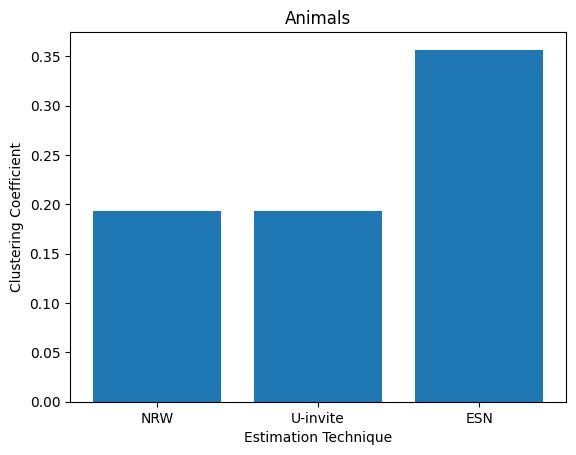

In [ ]:
x = ["NRW", "U-invite", "ESN"]
plt.bar(x, animal_clustering_coefs)
plt.title("Animals")
plt.ylabel("Clustering Coefficient")
plt.xlabel("Estimation Technique")

Text(0.5, 0, 'Estimation Technique')

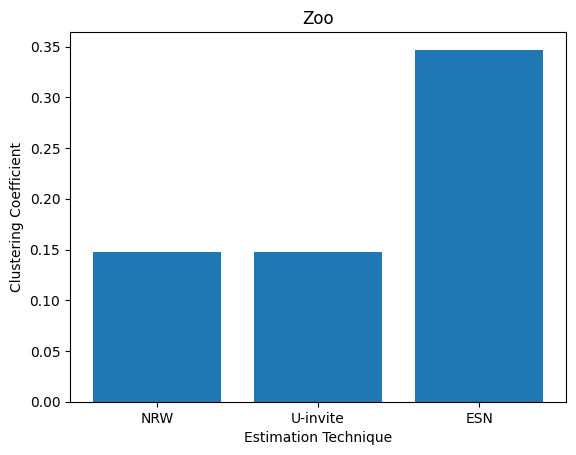

In [ ]:
plt.bar(x, zoo_clustering_coefs)
plt.title("Zoo")
plt.ylabel("Clustering Coefficient")
plt.xlabel("Estimation Technique")

Text(0.5, 0, 'Estimation Technique')

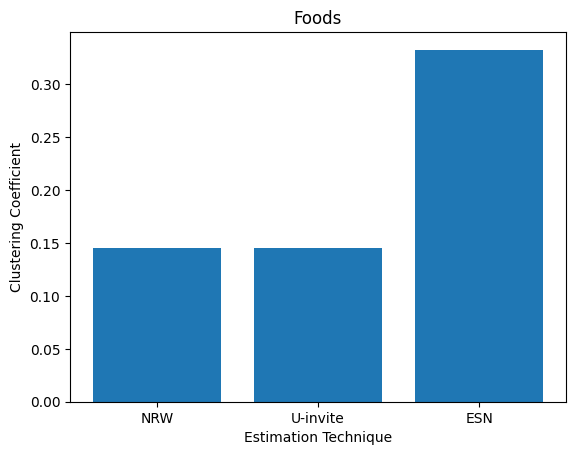

In [ ]:
plt.bar(x, food_clustering_coefs)
plt.title("Foods")
plt.ylabel("Clustering Coefficient")
plt.xlabel("Estimation Technique")

Text(0.5, 0, 'Estimation Technique')

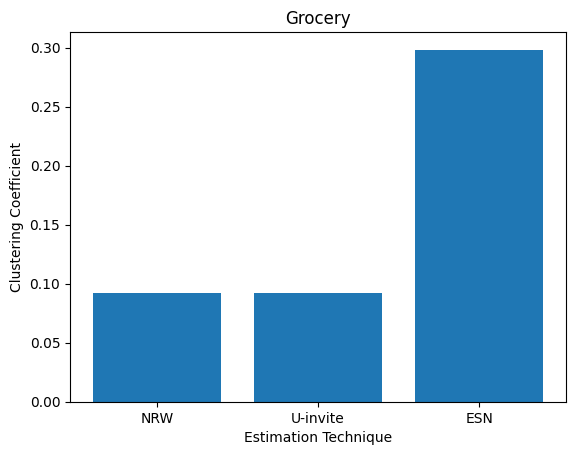

In [ ]:
plt.bar(x, grocery_clustering_coefs)
plt.title("Grocery")
plt.ylabel("Clustering Coefficient")
plt.xlabel("Estimation Technique")

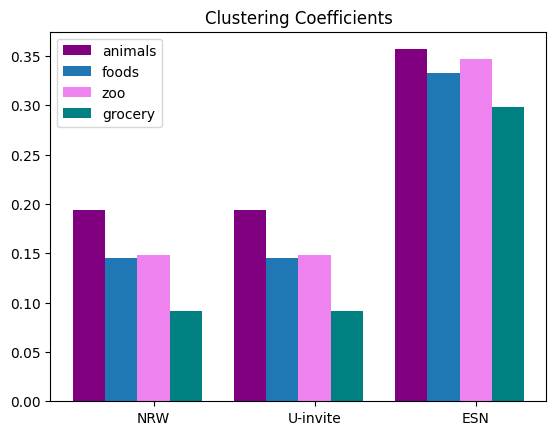

In [ ]:
x_axis = np.arange(len(x))
plt.bar(x_axis-0.4, animal_clustering_coefs, 0.2, label="animals", color="purple")
plt.bar(x_axis-0.2, food_clustering_coefs, 0.2, label="foods")
plt.bar(x_axis, zoo_clustering_coefs, 0.2, label="zoo", color="violet")
plt.bar(x_axis+0.2, grocery_clustering_coefs, 0.2, label="grocery", color="teal")
plt.xticks(x_axis, x)
plt.title("Clustering Coefficients")
plt.legend()

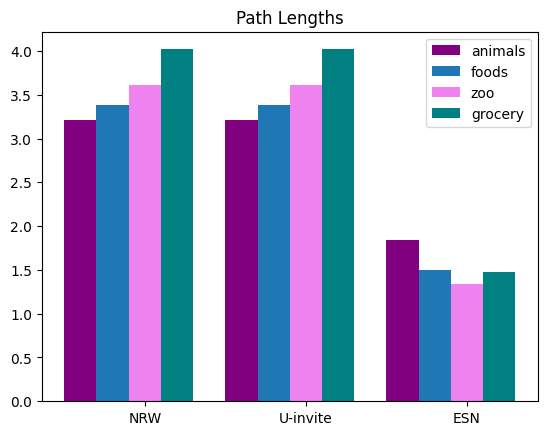

In [ ]:
x_axis = np.arange(len(x))
plt.bar(x_axis-0.4, animal_path_lengths, 0.2, label="animals", color="purple")
plt.bar(x_axis-0.2, food_path_lengths, 0.2, label="foods")
plt.bar(x_axis, zoo_path_lengths, 0.2, label="zoo", color="violet")
plt.bar(x_axis+0.2, grocery_path_lengths, 0.2, label="grocery", color="teal")
plt.xticks(x_axis, x)
plt.title("Path Lengths")
plt.legend()

In [ ]:
# get network metrics
# participants 25 and 27 got their grocery lists cut
def network_metrics(data, lists, similarity_threshold=0.33, num_parts=37):

  graphs = []
  clustering_coefs = []
  edge_nums = []
  node_nums = []
  path_lengths = []

  for i in range(num_parts*2):
    if i % 2 == 0:
      nrw_network = naiveRandomWalk(data.Xs[i:i+2], numnodes=data.groupnumnodes)
      nrw_G = nrw_g(nrw_network, data.groupnumnodes, data.groupitems)

      uinvite_network, ll = uinvite([data.Xs[i], data.Xs[i+1]],    # provide fluency lists
                                            datamodel,                # specify data model
                                            fitinfo=fitinfo,          # specify fit info
                                            debug=True,
                                            numnodes=lexplay_grocery_s.groupnumnodes)               # suppress print output to console when set to False

      u_G = uinvite_g(uinvite_network, data.groupnumnodes, data.groupitems)

      esn_G = euclidean_similarity_network(simplify_lists(lists[i:i+2]), embeddings_index, similarity_threshold=similarity_threshold)
      graphs.append([nrw_G, u_G, esn_G])
      clustering_coefs.append([nx.average_clustering(nrw_G), nx.average_clustering(u_G), nx.average_clustering(esn_G)])
      edge_nums.append([nrw_G.number_of_edges(), u_G.number_of_edges(), esn_G.number_of_edges()])
      node_nums.append([nrw_G.number_of_nodes(), u_G.number_of_nodes(), esn_G.number_of_nodes()])
      path_lengths.append([avg_shortest_path_length(nrw_G), avg_shortest_path_length(u_G), avg_shortest_path_length(esn_G)])

  return {'graphs': graphs, 'clustering_coefs': clustering_coefs, 'edge_nums': edge_nums, 'node_nums': node_nums, 'path_lengths': path_lengths}


In [ ]:
metrics = network_metrics(lexplay_animals_s, animal_lists_s)

<ipython-input-231-a76c1ba0ad31>:25: RuntimeWarning: invalid value encountered in divide
  t=a/sum(a.astype(float))


Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
censor_fault old: 0.25  censor_fault new:  0.22
censor_fault old: 0.22  censor_fault new:  0.22
censor_fault old: 0.22  censor_fault new:  0.16
censor_fault old: 0.16  censor_fault new:  0.17
censor_fault old: 0.17  censor_fault new:  0.1
censor_fault old: 0.1  censor_fault new:  0.09
censor_fault old: 0.09  censor_fault new:  0.07
7 changes
Pruning 1.2 ... 
censor_fault old: 0.07  censor_fault new:  0.07
1 changes
Pruning 1.3 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
censor_fault old: 0.05  censor_fault new:  0.04
1 changes
Pruning 1.2 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1

In [ ]:
len(metrics['clustering_coefs'])

37

In [ ]:
def id_array(relevant_ids, mult_num=2):
  new = []
  for id in relevant_ids:
    new += [id]*mult_num
  return new

In [ ]:
relevant_ids, toy_lists, animal_lists, food_lists, zoo_lists, grocery_lists = get_fluency_lists(df, age_year, age_mos, removemissing=True)

In [ ]:
ids = relevant_ids
relevant_id_indices = [id-1 for id in ids]
relevant_age_mos = [float(age_mos[id]) for id in relevant_id_indices]

In [ ]:
nrw_coefs = []
u_coefs = []
esn_coefs = []
for coefs in metrics['path_lengths']:
  nrw_coefs.append(coefs[0])
  u_coefs.append(coefs[1])
  esn_coefs.append(coefs[2])

Text(0, 0.5, 'average shortest path length')

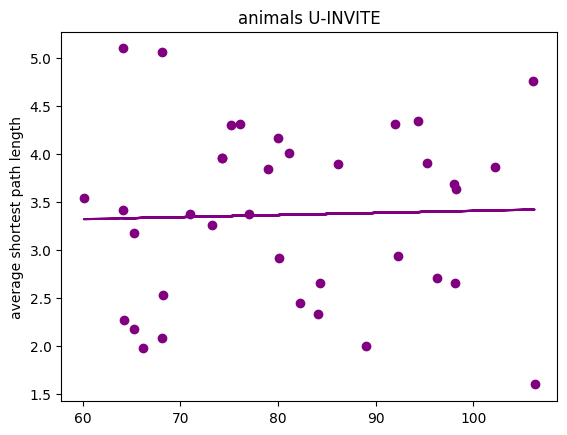

In [ ]:
plt.scatter(relevant_age_mos, u_coefs, color="purple")
#find line of best fit
a, b = np.polyfit(relevant_age_mos, u_coefs, 1)

#add line of best fit to plot
plt.plot(relevant_age_mos, a*np.array(relevant_age_mos)+b, color="purple")
plt.title("animals U-INVITE")
plt.ylabel("average shortest path length")

Text(0, 0.5, 'average shortest path length')

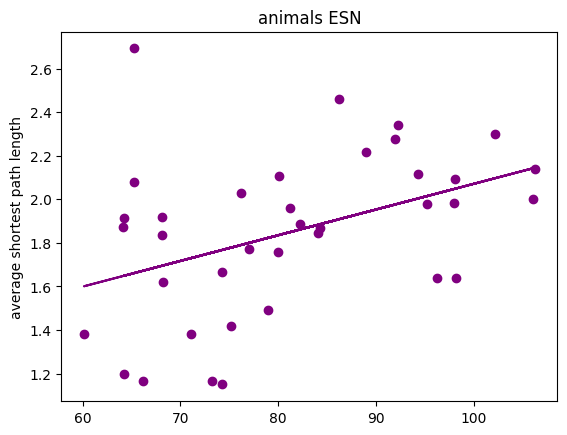

In [ ]:
plt.scatter(relevant_age_mos, esn_coefs, color="purple")
#find line of best fit
a, b = np.polyfit(relevant_age_mos, esn_coefs, 1)

#add line of best fit to plot
plt.plot(relevant_age_mos, a*np.array(relevant_age_mos)+b, color="purple")
plt.title("animals ESN")
plt.ylabel("average shortest path length")

In [ ]:
nrw_coefs = []
u_coefs = []
esn_coefs = []
for coefs in metrics['edge_nums']:
  nrw_coefs.append(coefs[0])
  u_coefs.append(coefs[1])
  esn_coefs.append(coefs[2])

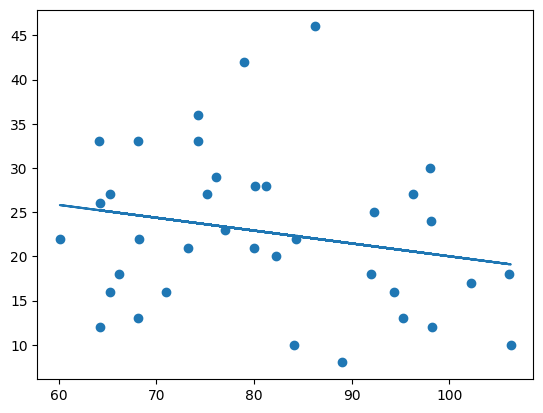

In [ ]:
plt.scatter(relevant_age_mos, u_coefs)
#find line of best fit
a, b = np.polyfit(relevant_age_mos, u_coefs, 1)

#add line of best fit to plot
plt.plot(relevant_age_mos, a*np.array(relevant_age_mos)+b)

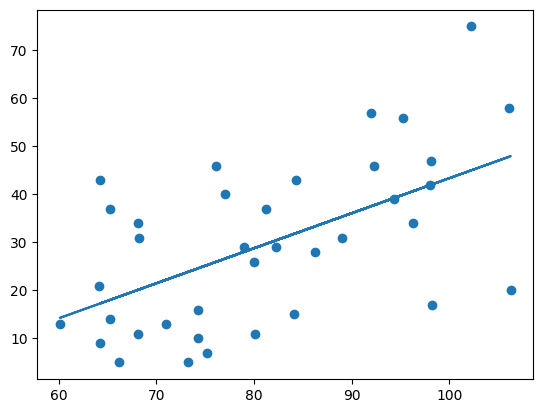

In [ ]:
plt.scatter(relevant_age_mos, esn_coefs)
#find line of best fit
a, b = np.polyfit(relevant_age_mos, esn_coefs, 1)

#add line of best fit to plot
plt.plot(relevant_age_mos, a*np.array(relevant_age_mos)+b)

In [ ]:
metrics = network_metrics(lexplay_foods_s, food_lists_s)

<ipython-input-231-a76c1ba0ad31>:25: RuntimeWarning: invalid value encountered in divide
  t=a/sum(a.astype(float))


Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
censor_fault old: 0.04  censor_fault new:  0.04
censor_fault old: 0.04  censor_fault new:  0.03
2 changes
Pruning 1.2 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
censor_fault old: 0.12  censor_fault new:  0.1
censor_fault old: 0.1  censor_fault new:  0.1
2 changes
Adding triangles 1.2 ... 
0 changes
Pruning 2.1 ... 
censor_fault old: 0.1  censor_fault new:  0.11
1 changes
Pruning 2.2 ... 
0 changes
Adding triangles 2.1 ... 
0 changes
Adding other edges 2.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruni

In [ ]:
nrw_coefs = []
u_coefs = []
esn_coefs = []
for coefs in metrics['path_lengths']:
  nrw_coefs.append(coefs[0])
  u_coefs.append(coefs[1])
  esn_coefs.append(coefs[2])

Text(0, 0.5, 'average shortest path length')

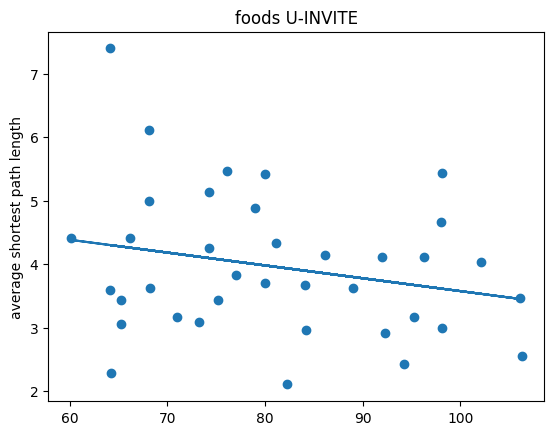

In [ ]:
plt.scatter(relevant_age_mos, u_coefs)
#find line of best fit
a, b = np.polyfit(relevant_age_mos, u_coefs, 1)

#add line of best fit to plot
plt.plot(relevant_age_mos, a*np.array(relevant_age_mos)+b)
plt.title("foods U-INVITE")
plt.ylabel("average shortest path length")

Text(0, 0.5, 'average shortest path length')

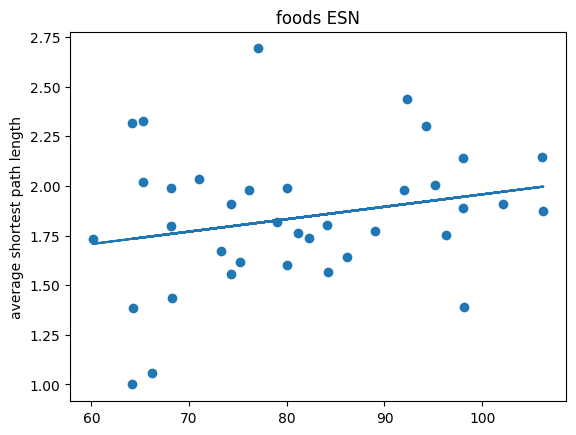

In [ ]:
plt.scatter(relevant_age_mos, esn_coefs)
#find line of best fit
a, b = np.polyfit(relevant_age_mos, esn_coefs, 1)

#add line of best fit to plot
plt.plot(relevant_age_mos, a*np.array(relevant_age_mos)+b)
plt.title("foods ESN")
plt.ylabel("average shortest path length")

In [ ]:
metrics = network_metrics(lexplay_zoo_s, simplify_lists(zoo_lists))

<ipython-input-231-a76c1ba0ad31>:25: RuntimeWarning: invalid value encountered in divide
  t=a/sum(a.astype(float))


Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
censor_fault old: 0.03  censor_fault new:  0.02
1 changes
Pruning 1.2 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
censor_fault old: 0.02  censor_fault new:  0.02
1 changes
Pruning 1.2 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
censor_fault old: 0.11  censor_fault new:  0.08
1 changes
Pruning 1.2 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Addin

In [ ]:
nrw_coefs = []
u_coefs = []
esn_coefs = []
for coefs in metrics['path_lengths']:
  nrw_coefs.append(coefs[0])
  u_coefs.append(coefs[1])
  esn_coefs.append(coefs[2])

Text(0, 0.5, 'average shortest path length')

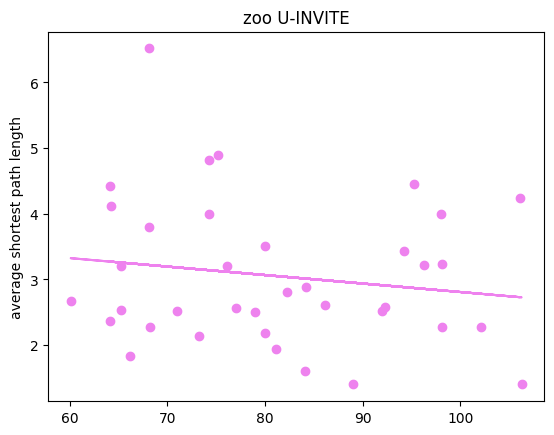

In [ ]:
plt.scatter(relevant_age_mos, u_coefs, color="violet")
#find line of best fit
a, b = np.polyfit(relevant_age_mos, u_coefs, 1)

#add line of best fit to plot
plt.plot(relevant_age_mos, a*np.array(relevant_age_mos)+b, color="violet")
plt.title("zoo U-INVITE")
plt.ylabel("average shortest path length")

Text(0, 0.5, 'average shortest path length')

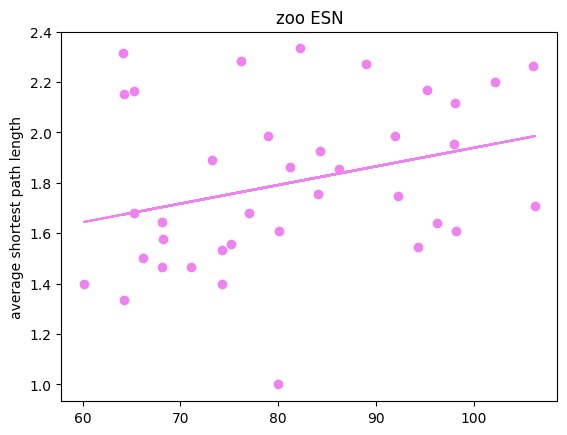

In [ ]:
plt.scatter(relevant_age_mos, esn_coefs, color="violet")
#find line of best fit
a, b = np.polyfit(relevant_age_mos, esn_coefs, 1)

#add line of best fit to plot
plt.plot(relevant_age_mos, a*np.array(relevant_age_mos)+b, color="violet")
plt.title("zoo ESN")
plt.ylabel("average shortest path length")

In [ ]:
metrics = network_metrics(lexplay_grocery_s, simplify_lists(grocery_lists))

<ipython-input-231-a76c1ba0ad31>:25: RuntimeWarning: invalid value encountered in divide
  t=a/sum(a.astype(float))


Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
censor_fault old: 0.0  censor_fault new:  0.0
1 changes
Pruning 1.2 ... 
0 changes
Adding triangles 1.1 ... 
censor_fault old: 0.0  censor_fault new:  0.0
1 changes
Adding triangles 1.2 ... 
0 changes
Pruning 2.1 ... 
0 changes
Adding other edges 2.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
censor_fault old: 0.03  censor_fault new:  0.02
1 changes
Adding triangles 1.2 ... 
0 changes
Pruning 2.1 ... 
0 changes
Adding other edges 2.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
0 changes
Adding other edges 1.1 ... 
0 changes
Pruning 1.1 ... 
0 changes
Adding triangles 1.1 ... 
censor_fault old: 0.08  censor_fault new:  0.07


In [ ]:
nrw_coefs = []
u_coefs = []
esn_coefs = []
for coefs in metrics['path_lengths']:
  nrw_coefs.append(coefs[0])
  u_coefs.append(coefs[1])
  esn_coefs.append(coefs[2])

Text(0.5, 1.0, 'grocery U-INVITE')

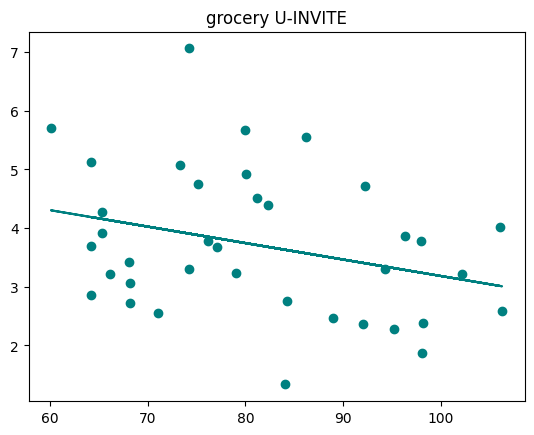

In [ ]:
plt.scatter(relevant_age_mos, u_coefs, color="teal")
#find line of best fit
a, b = np.polyfit(relevant_age_mos, u_coefs, 1)

#add line of best fit to plot
plt.plot(relevant_age_mos, a*np.array(relevant_age_mos)+b, color="teal")
plt.title("grocery U-INVITE")

Text(0.5, 1.0, 'grocery ESN')

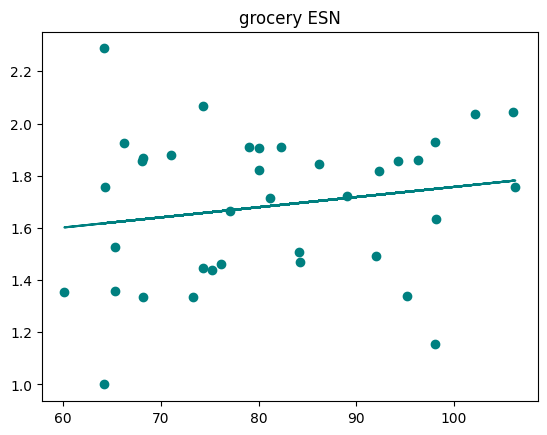

In [ ]:
plt.scatter(relevant_age_mos, esn_coefs, color="teal")
#find line of best fit
a, b = np.polyfit(relevant_age_mos, esn_coefs, 1)

#add line of best fit to plot
plt.plot(relevant_age_mos, a*np.array(relevant_age_mos)+b, color="teal")
plt.title("grocery ESN")